# GRILES

## Imports

In [1]:
import warnings

import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mutual_info_score

from scipy.stats import normaltest, linregress, pearsonr, spearmanr, kendalltau

## Data

### FRED API Key

In [2]:
# Replace with your FRED API key
api_key = 'faa595b512815df9501e6cbd55643edc'

### FRED API Function

In [3]:
# Function to get data from FRED
def get_fred_data(series_id, start_date='2000-01-01', end_date='2024-01-01', api_key=api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&frequency=m&start_date={start_date}&end_date={end_date}'
    response = requests.get(url)
    
    # Check if the response status is OK
    if response.status_code != 200:
        print(f"Error fetching data for {series_id}: {response.status_code}")
        print(response.text)  # Print the response for debugging
        return pd.Series()  # Return an empty series

    data = response.json()

    # Check if 'observations' exists in the response
    if 'observations' not in data:
        print(f"'observations' key not found in the response for {series_id}. Response: {data}")
        return pd.Series()  # Return an empty series

    observations = data['observations']
    dates = [obs['date'] for obs in observations]
    
    # Safely convert values to float, replacing non-numeric values with NaN
    values = []
    for obs in observations:
        try:
            value = float(obs['value'])
        except ValueError:
            value = np.nan  # Replace non-numeric value with NaN
        values.append(value)
    
    # Create a pandas Series
    series = pd.Series(data=values, index=pd.to_datetime(dates), name=series_id)
    
    # Resample the data to monthly frequency and take the average
    monthly_series = series.resample('ME').mean()
    
    return monthly_series

### Data Specs

In [4]:
series_ids = {
    'Growth': {
        'DGORDER': 'Durable Goods Orders: New orders for long-lasting manufactured goods, indicating future industrial activity.',
        'INDPRO': 'Industrial Production Index: Output of industrial sector, including manufacturing, mining, and utilities.',
        'ISRATIO': 'Inventories to Sales Ratio: Indicator of business cycle phases and economic health.',
        'MANEMP': 'Manufacturing Employment: Employment levels in manufacturing sector, part of ISM Manufacturing PMI.',
        'PAYEMS': 'Nonfarm Payrolls: Total non-agricultural employment in the economy.',
        'RSXFS': 'Retail Sales: Consumer spending indicator based on retail store receipts.',
        'USALOLITONOSTSAM': 'Composite Leading Indicator (CLI): Forward-looking index for economic activity turning points.',
        'USPHCI': 'Personal Consumption Expenditures (PCE): Consumer spending trends, major GDP component.',
        'CIVPART': 'Civilian Labor Force Participation Rate: Percentage of working-age population in the labor force.',
    },
    'Risk': {
        'STLFSI4': 'St. Louis Fed Financial Stress Index: Measure of overall financial system stress.',
        'KCFSI': 'Kansas City Financial Stress Index: Measure of stress in the U.S. financial system.',
    },
    'Inflation': {
        'CORESTICKM159SFRBATL': 'Atlanta Fed Sticky-Price CPI: Inflation for items with infrequent price changes.',
        'CPIAUCSL': 'Consumer Price Index (CPI): Average price changes for urban consumers\' goods and services.',
        'CPILFESL': 'Core CPI: CPI excluding volatile food and energy prices.',
        'MEDCPIM158SFRBCLE': 'Cleveland Fed Median CPI: Median price change in consumer goods basket.',
        'OECDCPALTT01GYM': 'OECD CPI: Year-over-year consumer price changes across OECD countries.',
        'PCEPI': 'PCE Price Index: Fed\'s preferred measure of inflation in consumer goods and services.',
        'PPIACO': 'Producer Price Index (PPI): Price changes received by domestic producers for their output.',
    },
    'Liquidity': {
        'BOGMBASE': 'Monetary Base: Sum of currency in circulation and reserve balances at Fed banks.',
        'ECBASSETSW': 'European Central Bank Assets: Total ECB assets, reflecting monetary policy stance.',
        'JPNASSETS': 'Bank of Japan Assets: Total BOJ assets, indicating monetary policy operations.',
        'M1REAL': 'Real M1 Money Stock: Inflation-adjusted measure of most liquid money components.',
        'M2REAL': 'Real M2 Money Stock: Inflation-adjusted broader money supply measure.',
        'RSBKCRNS': 'Reserve Bank Credit: Credit extended by Federal Reserve Banks.',
        'SNBMONTBASE': 'Swiss National Bank Monetary Base: Money circulating in Swiss economy.',
        'TOTRESNS': 'Total Reserves of Depository Institutions: Overall banking system liquidity indicator.',
        'WALCL': 'Total Fed Assets: Federal Reserve\'s balance sheet size and liquidity operations.',
        'WDDNS': 'Wholesale and Durables Dealer Inventories: Business liquidity and economic expectations indicator.',
    },
    'Employ': {
        'UNRATE': 'Unemployment Rate: Percentage of the labor force that is unemployed.',
        'USPRIV': 'All Employees, Total Private: Total number of employees in the private sector.',
        'USGOVT': 'All Employees, Government: Total number of employees in the government sector.',
        'CES4348400001': 'All Employees, Truck Transportation',
        'CES4348500001': 'All Employees, Transit and Ground Passenger Transportation',
        'CES4348100001': 'All Employees, Air Transportation',
        'USCONS': 'All Employees, Construction: Total number of employees in the construction industry.',
    },
    'Sentiment': {
        'UMCSENT': 'University of Michigan Consumer Sentiment Index: Consumer confidence measure.',
        'PSAVERT': 'Personal Saving Rate: Percentage of disposable income saved by households.',
    }
}

### Get Data

In [5]:
# Separate DataFrames for each category
growth_df = pd.DataFrame()
inflation_df = pd.DataFrame()
risk_df = pd.DataFrame()
liquidity_df = pd.DataFrame()
sentiment_df = pd.DataFrame()
employ_df = pd.DataFrame()

# Fetch data for each metric and assign to separate DataFrames
for category, ids in series_ids.items():
    category_data = {}
    for series_id in ids:
        print(f'Fetching data for {series_id}...')
        series_data = get_fred_data(series_id, api_key=api_key)
        if not series_data.empty:  # Only add data if the series is not empty
            category_data[series_id] = series_data
    
    if category == 'Growth':
        growth_df = pd.DataFrame(category_data)
    elif category == 'Inflation':
        inflation_df = pd.DataFrame(category_data)
    elif category == 'Risk':
        risk_df = pd.DataFrame(category_data)
    elif category == 'Liquidity':
        liquidity_df = pd.DataFrame(category_data)
    elif category == 'Sentiment':
        sentiment_df = pd.DataFrame(category_data)
    elif category == 'Employ':
        employ_df = pd.DataFrame(category_data)

Fetching data for DGORDER...
Fetching data for INDPRO...
Fetching data for ISRATIO...
Fetching data for MANEMP...
Fetching data for PAYEMS...
Fetching data for RSXFS...
Fetching data for USALOLITONOSTSAM...
Fetching data for USPHCI...
Fetching data for CIVPART...
Fetching data for STLFSI4...
Fetching data for KCFSI...
Fetching data for CORESTICKM159SFRBATL...
Fetching data for CPIAUCSL...
Fetching data for CPILFESL...
Fetching data for MEDCPIM158SFRBCLE...
Fetching data for OECDCPALTT01GYM...
Fetching data for PCEPI...
Fetching data for PPIACO...
Fetching data for BOGMBASE...
Fetching data for ECBASSETSW...
Fetching data for JPNASSETS...
Fetching data for M1REAL...
Fetching data for M2REAL...
Fetching data for RSBKCRNS...
Fetching data for SNBMONTBASE...
Fetching data for TOTRESNS...
Fetching data for WALCL...
Fetching data for WDDNS...
Fetching data for UNRATE...
Fetching data for USPRIV...
Fetching data for USGOVT...
Fetching data for CES4348400001...
Fetching data for CES4348500001.

## Cleaning

### Fix Cols

In [6]:
growth_df['ISRATIO'] = 1 / growth_df['ISRATIO']
employ_df['Priv/Gov'] = employ_df['USPRIV'] / employ_df['USGOVT']
employ_df['UNRATE'] = 100 - employ_df['UNRATE']


employ_df.drop(columns=['USPRIV', 'USGOVT'], inplace=True)

### Date Cutoff

In [7]:
# Cutoff each DataFrame from 1999 forward
growth_df = growth_df[growth_df.index >= '2000-01-01']
risk_df = risk_df[risk_df.index >= '2000-01-01']
inflation_df = inflation_df[inflation_df.index >= '2000-01-01']
liquidity_df = liquidity_df[liquidity_df.index >= '2000-01-01']
employ_df = employ_df[employ_df.index >= '2000-01-01']
sentiment_df = sentiment_df[sentiment_df.index >= '2000-01-01']

### % Change

In [8]:
# Calculate the 3-month percentage change from 3 months ago
growth_df_pct_change = growth_df.pct_change(periods=3) * 100
risk_df_pct_change = risk_df.pct_change(periods=3) * 100
inflation_df_pct_change = inflation_df.pct_change(periods=3) * 100
liquidity_df_pct_change = liquidity_df.pct_change(periods=3) * 100
employ_df_pct_change = employ_df.pct_change(periods=3) * 100
sentiment_df_pct_change = sentiment_df.pct_change(periods=3) * 100

# Drop NaN values after the percentage change calculation
growth_df_pct_change = growth_df_pct_change.dropna()
risk_df_pct_change = risk_df_pct_change.dropna()
inflation_df_pct_change = inflation_df_pct_change.dropna()
liquidity_df_pct_change = liquidity_df_pct_change.dropna()
employ_df_pct_change = employ_df_pct_change.dropna()
sentiment_pct_change = sentiment_df_pct_change.dropna()

/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_47031/3520093528.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  growth_df_pct_change = growth_df.pct_change(periods=3) * 100
/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_47031/3520093528.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  risk_df_pct_change = risk_df.pct_change(periods=3) * 100
/var/folders/b8/z397yjvn3xj72ht4tz6zzjs00000gn/T/ipykernel_47031/3520093528.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in a

### Export to Parquet

In [9]:
# Merge all dataframes on their index using an outer join to retain all unique dates
merged_df = growth_df \
    .join(inflation_df, how='outer', lsuffix='_growth', rsuffix='_inflation') \
    .join(risk_df, how='outer', rsuffix='_risk') \
    .join(liquidity_df, how='outer', rsuffix='_liquidity') \
    .join(sentiment_df, how='outer', rsuffix='_sentiment') \
    .join(employ_df, how='outer', rsuffix='_sentiment')

# Drop any rows with missing values to ensure we have complete data for further analysis
merged_df_clean = merged_df.dropna()

# Export the cleaned merged DataFrame to Parquet
merged_df_clean.to_parquet('merged_df_clean.parquet')

print("Merged DataFrame exported to 'merged_df_clean.parquet'.")

Merged DataFrame exported to 'merged_df_clean.parquet'.


### Scale via RobustScaler

In [10]:
# This will align all DataFrames to have the same index (intersection of all indexes)
common_index = growth_df_pct_change.index.intersection(liquidity_df_pct_change.index).intersection(sentiment_df_pct_change.index)

growth_df_pct_change = growth_df_pct_change.loc[common_index]
inflation_df_pct_change = inflation_df_pct_change.loc[common_index]
risk_df_pct_change = risk_df_pct_change.loc[common_index]
liquidity_df_pct_change = liquidity_df_pct_change.loc[common_index]
sentiment_df_pct_change = sentiment_df_pct_change.loc[common_index]
employ_df_pct_change = employ_df_pct_change.loc[common_index]

# Apply RobustScaler to standardize each dataset
scaler = RobustScaler()

# Apply the scaler to each DataFrame and overwrite the original variable names
growth_df_pct_change = pd.DataFrame(scaler.fit_transform(growth_df_pct_change), index=growth_df_pct_change.index, columns=growth_df_pct_change.columns)
inflation_df_pct_change = pd.DataFrame(scaler.fit_transform(inflation_df_pct_change), index=inflation_df_pct_change.index, columns=inflation_df_pct_change.columns)
risk_df_pct_change = pd.DataFrame(scaler.fit_transform(risk_df_pct_change), index=risk_df_pct_change.index, columns=risk_df_pct_change.columns)
liquidity_df_pct_change = pd.DataFrame(scaler.fit_transform(liquidity_df_pct_change), index=liquidity_df_pct_change.index, columns=liquidity_df_pct_change.columns)
sentiment_df_pct_change = pd.DataFrame(scaler.fit_transform(sentiment_df_pct_change), index=sentiment_df_pct_change.index, columns=sentiment_pct_change.columns)
employ_df_pct_change = pd.DataFrame(scaler.fit_transform(employ_df_pct_change), index=employ_df_pct_change.index, columns=employ_df_pct_change.columns)

## Exploration

### Growth

In [11]:
growth_df_pct_change

,DGORDER,INDPRO,ISRATIO,MANEMP,PAYEMS,RSXFS,USALOLITONOSTSAM,USPHCI,CIVPART
2003-04-30,-0.215412,-0.975108,-1.374979,-2.606481,-2.797156,-0.481132,0.160401,-3.355100,0.000000
2003-05-31,-0.421645,-1.105678,-0.461672,-2.303321,-2.320797,0.320885,0.577878,-2.977832,0.000000
2003-06-30,-0.005933,-0.771418,0.000000,-2.350716,-1.691227,0.007714,0.987180,-2.708459,0.651128
2003-07-31,0.297650,0.175639,2.377782,-2.163302,-1.544948,0.680978,1.319706,-1.954571,-0.650147
2003-08-31,0.020958,0.026896,2.395796,-1.916664,-1.700406,1.515086,1.566159,-1.578796,-0.975221
...,...,...,...,...,...,...,...,...,...
2024-02-29,-1.444000,-0.462442,-0.461672,-0.050825,0.407171,-0.418217,0.383386,-0.578135,-1.031125
2024-03-31,-0.490863,-0.439113,0.000000,-0.248300,0.453984,-0.365299,0.188696,-0.078732,0.690716
2024-04-30,0.278000,0.493008,0.461672,-0.237294,0.077923,0.070029,-0.053389,-0.389333,0.690716
2024-05-31,0.066108,0.107356,-0.458326,-0.105735,0.025159,-0.202830,-0.053389,-0.092436,0.000000


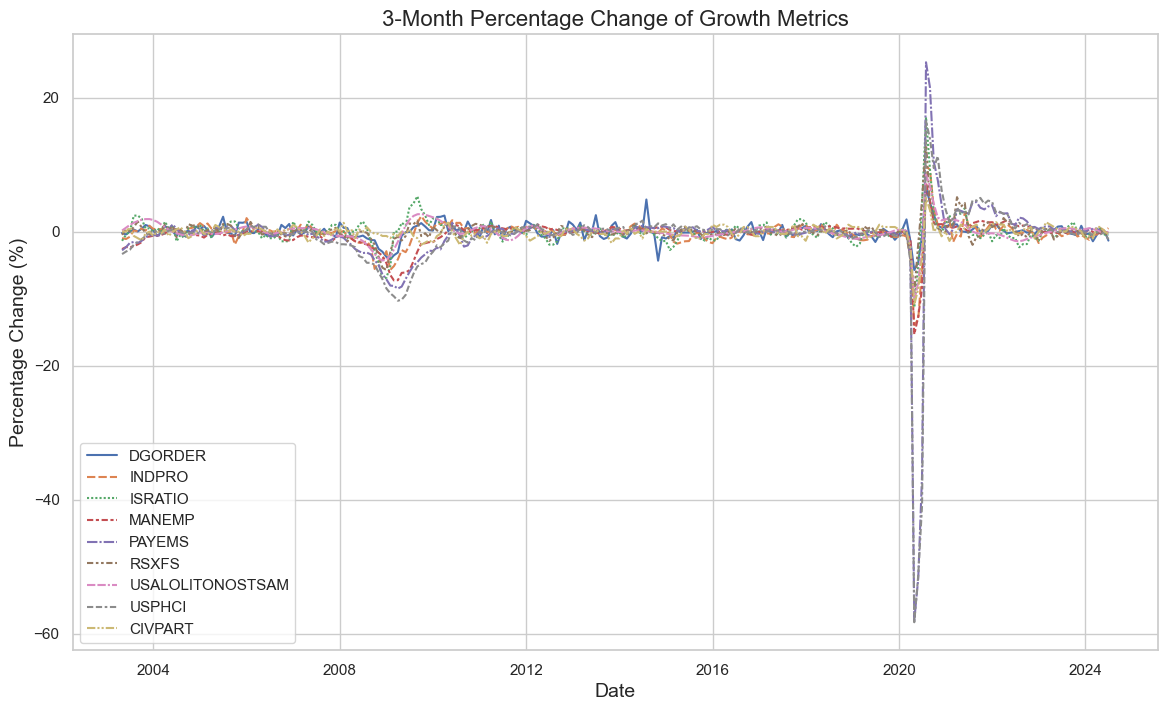

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Set the figure size to be larger
plt.figure(figsize=(14, 8))

# Plot the growth_df_pct_change DataFrame
sns.lineplot(data=growth_df_pct_change)

# Add title and labels
plt.title("3-Month Percentage Change of Growth Metrics", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage Change (%)", fontsize=14)

# Show the plot
plt.show()


### Risk

In [13]:
risk_df_pct_change.describe()

,STLFSI4,KCFSI
count,255.000000,255.000000
mean,1.373659,-0.475947
std,19.245047,5.911227
min,-17.990297,-73.422559
25%,-0.651496,-0.598285
50%,0.000000,0.000000
75%,0.348504,0.401715
max,275.755242,39.588489


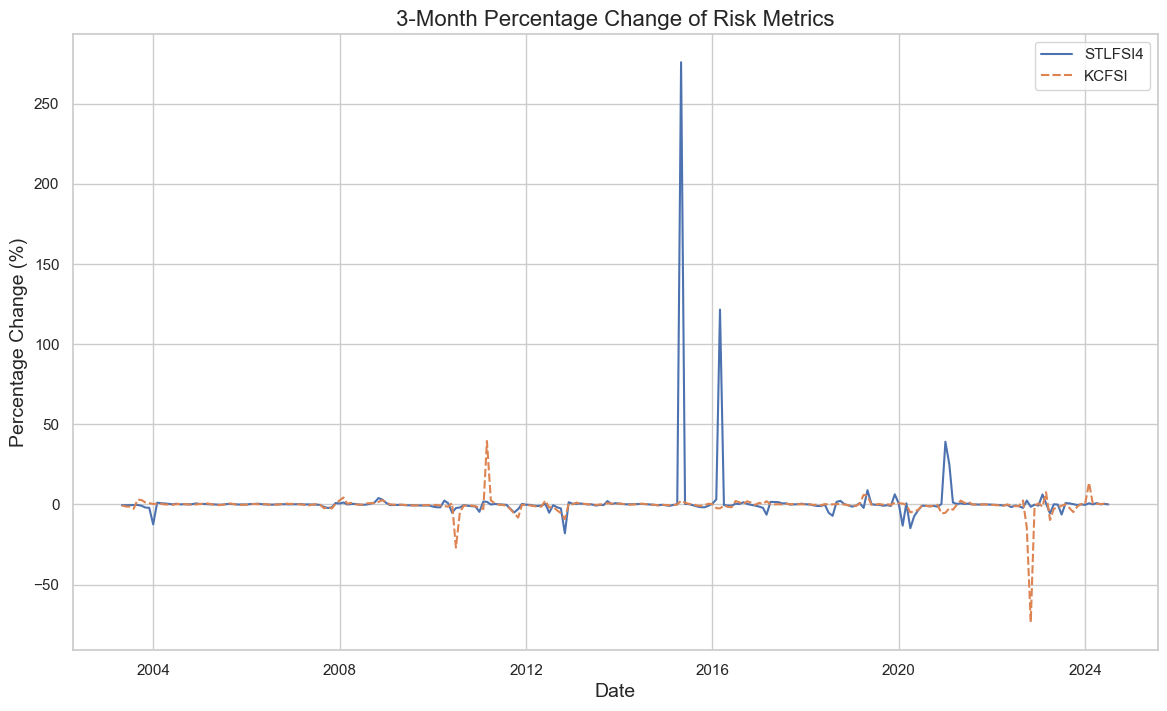

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Set the figure size to be larger
plt.figure(figsize=(14, 8))

# Plot the growth_df_pct_change DataFrame
sns.lineplot(data=risk_df_pct_change)

# Add title and labels
plt.title("3-Month Percentage Change of Risk Metrics", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage Change (%)", fontsize=14)

# Show the plot
plt.show()


### Inflation

In [15]:
inflation_df_pct_change

,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,MEDCPIM158SFRBCLE,OECDCPALTT01GYM,PCEPI,PPIACO
2003-04-30,-0.900444,-0.478764,-1.968429,-1.630263,-0.252216,-0.051129,0.127979
2003-05-31,-1.008182,-1.612550,-1.321352,-1.010932,-0.687729,-1.150169,-0.481570
2003-06-30,-1.038002,-1.698409,-1.105622,-0.047231,-0.736452,-1.453318,-1.039076
2003-07-31,-0.698978,-0.567667,-0.242703,8.111119,-0.295443,-0.502862,-0.027891
2003-08-31,-0.607391,0.393648,-0.677294,2.494675,-0.091576,0.428818,0.073460
...,...,...,...,...,...,...,...
2024-02-29,-0.477293,0.567577,2.091524,-0.275828,-0.040685,0.717990,0.027697
2024-03-31,-0.099914,0.800860,2.441751,0.044290,-0.097767,1.159638,0.468272
2024-04-30,-0.334750,0.812901,2.020855,-0.786722,0.024841,0.829059,0.525909
2024-05-31,-0.196542,0.111188,1.204400,-0.761242,0.112577,0.212988,-0.209000


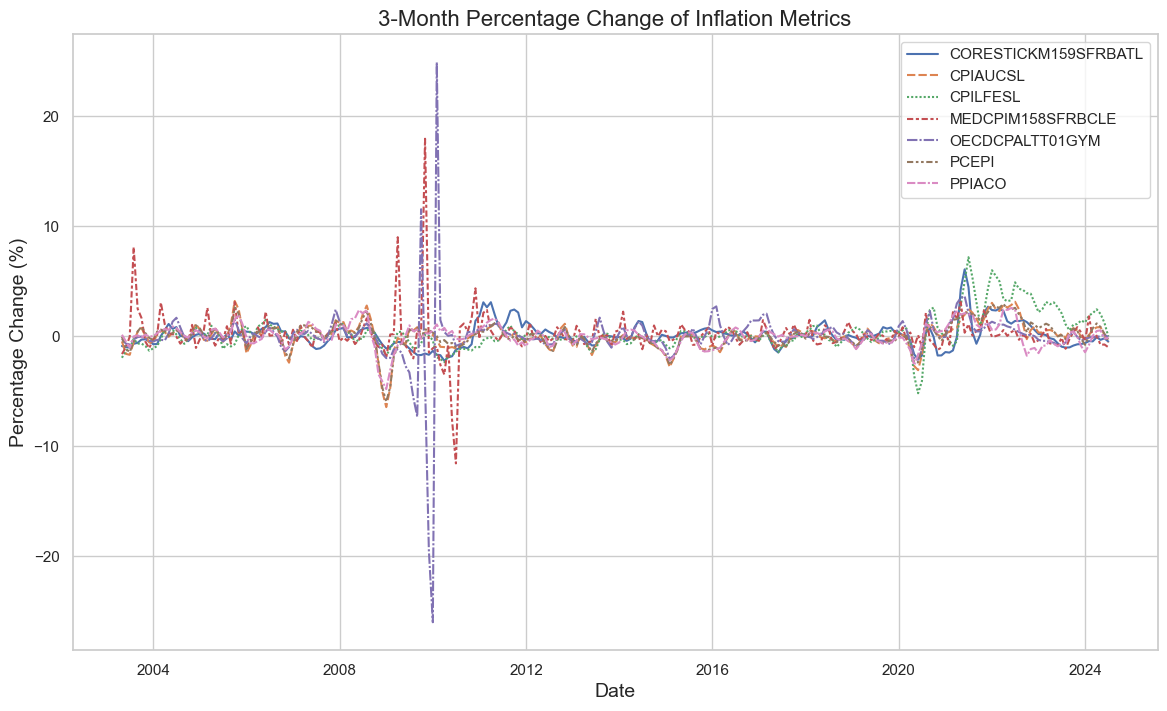

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Set the figure size to be larger
plt.figure(figsize=(14, 8))

# Plot the growth_df_pct_change DataFrame
sns.lineplot(data=inflation_df_pct_change)

# Add title and labels
plt.title("3-Month Percentage Change of Inflation Metrics", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage Change (%)", fontsize=14)

# Show the plot
plt.show()


### Liquidity

In [17]:
liquidity_df_pct_change

,BOGMBASE,ECBASSETSW,JPNASSETS,M1REAL,M2REAL,RSBKCRNS,SNBMONTBASE,TOTRESNS,WALCL,WDDNS
2003-04-30,0.145132,-0.472302,0.182223,0.287584,0.415171,0.291541,0.074064,-0.469522,0.226260,0.052547
2003-05-31,0.226908,-0.496791,-0.670219,0.834071,1.280345,0.447805,0.475387,-0.075542,0.393596,0.526695
2003-06-30,0.121574,-0.425211,-2.574285,1.221043,1.526467,0.341205,0.038864,0.314513,0.324367,1.047474
2003-07-31,0.061736,0.168571,-0.692149,0.778889,1.079860,0.044487,0.586471,0.565981,-0.031577,0.602791
2003-08-31,0.033117,0.210091,-0.749687,0.198043,0.567282,-0.034666,0.400535,1.038016,-0.128039,0.413225
...,...,...,...,...,...,...,...,...,...,...
2024-02-29,0.486167,-0.761448,-0.283046,-0.901722,-1.168215,-0.979472,0.042297,0.460103,-0.904681,-0.305150
2024-03-31,0.019911,-0.858973,-0.235600,-0.833261,-1.120394,-0.868159,-0.069472,0.104520,-0.857343,-0.356732
2024-04-30,-0.493322,-1.172024,-0.353599,-0.777711,-1.029595,-1.020796,-0.170309,-0.284083,-0.991014,0.409069
2024-05-31,-0.913187,-1.092075,-0.385087,-0.402777,-0.341074,-1.107296,-0.685902,-0.618448,-1.110212,0.385155


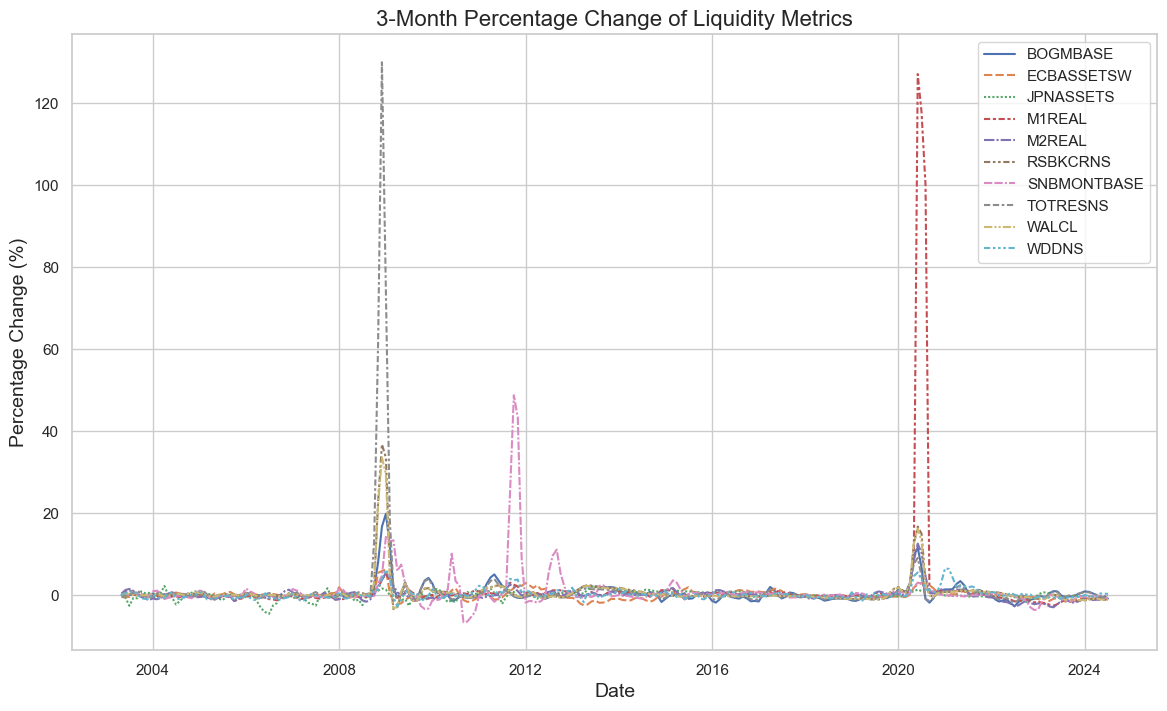

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Set the figure size to be larger
plt.figure(figsize=(14, 8))

# Plot the growth_df_pct_change DataFrame
sns.lineplot(data=liquidity_df_pct_change)

# Add title and labels
plt.title("3-Month Percentage Change of Liquidity Metrics", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage Change (%)", fontsize=14)

# Show the plot
plt.show()


### Employment

In [19]:
employ_df_pct_change

,UNRATE,CES4348400001,CES4348500001,CES4348100001,USCONS,Priv/Gov
2003-04-30,-0.761884,-1.071197,0.837167,-3.892676,-0.985063,-0.804481
2003-05-31,-0.762427,-0.798664,-0.191791,-3.999583,-0.157718,-0.317266
2003-06-30,-1.273384,-1.050347,0.404387,-4.174933,0.304692,-0.492662
2003-07-31,-0.762970,-0.276727,-0.811865,-3.336860,-0.052627,-0.811155
2003-08-31,-0.251470,-0.041829,-0.192136,-2.273001,0.067633,-0.431545
...,...,...,...,...,...,...
2024-02-29,-0.750754,-0.167969,0.087263,0.614393,0.102468,-1.120171
2024-03-31,-0.501112,-0.128231,0.027409,0.126116,0.339944,-1.108786
2024-04-30,-0.750754,-0.265379,0.691619,0.395146,-0.052875,-0.782403
2024-05-31,-0.501631,-0.733197,0.552567,0.097908,-0.192681,-0.423915


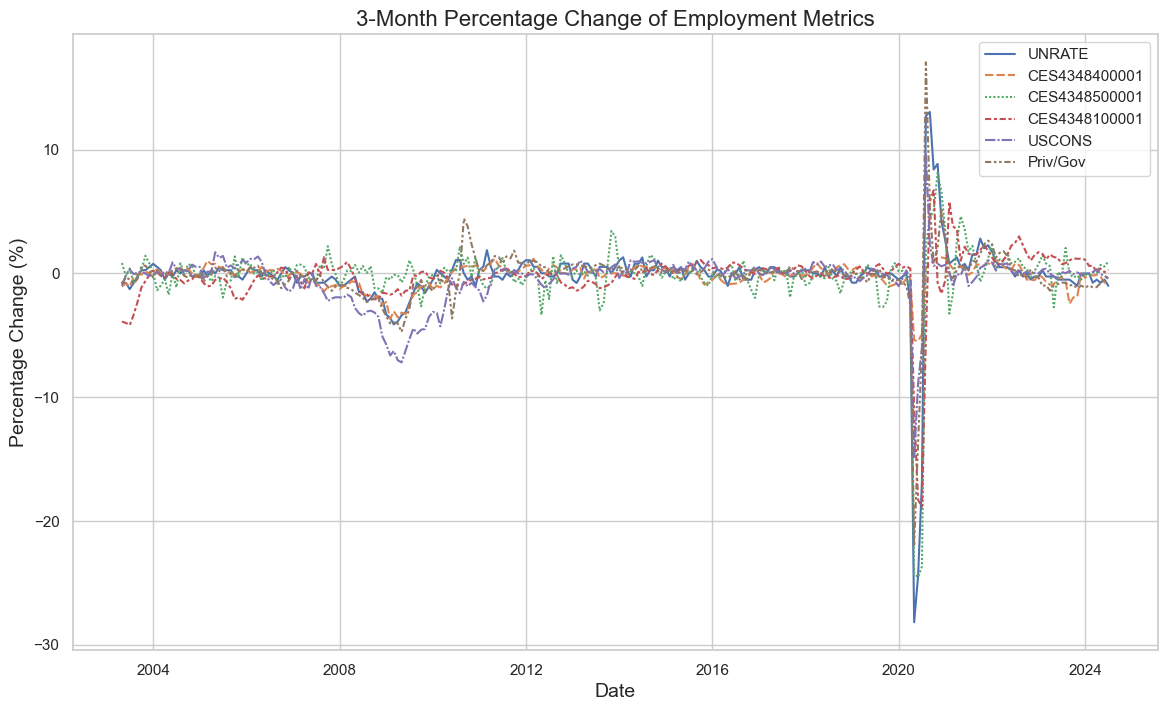

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Set the figure size to be larger
plt.figure(figsize=(14, 8))

# Plot the growth_df_pct_change DataFrame
sns.lineplot(data=employ_df_pct_change)

# Add title and labels
plt.title("3-Month Percentage Change of Employment Metrics", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage Change (%)", fontsize=14)

# Show the plot
plt.show()


### Sentiment

In [21]:
sentiment_df_pct_change

,UMCSENT,PSAVERT
2003-04-30,0.388503,-0.282084
2003-05-31,1.446851,0.095836
2003-06-30,1.478280,0.203408
2003-07-31,0.517517,0.897028
2003-08-31,-0.330881,0.376112
...,...,...
2024-02-29,2.435228,0.000000
2024-03-31,1.315549,-0.138430
2024-04-30,-0.256925,-0.622936
2024-05-31,-1.020532,-0.269378


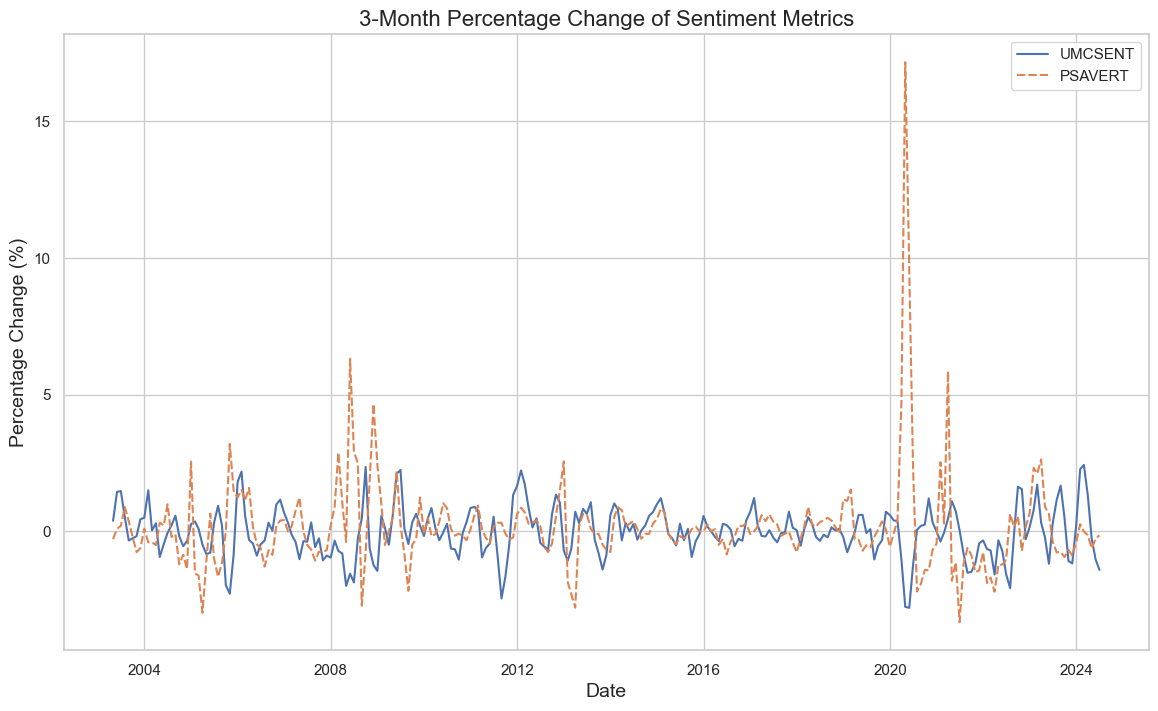

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn style for the plot
sns.set(style="whitegrid")

# Set the figure size to be larger
plt.figure(figsize=(14, 8))

# Plot the growth_df_pct_change DataFrame
sns.lineplot(data=sentiment_df_pct_change)

# Add title and labels
plt.title("3-Month Percentage Change of Sentiment Metrics", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage Change (%)", fontsize=14)

# Show the plot
plt.show()

## Internal Correlations

### Pearson


Growth Data Pearson Correlation Heatmap:


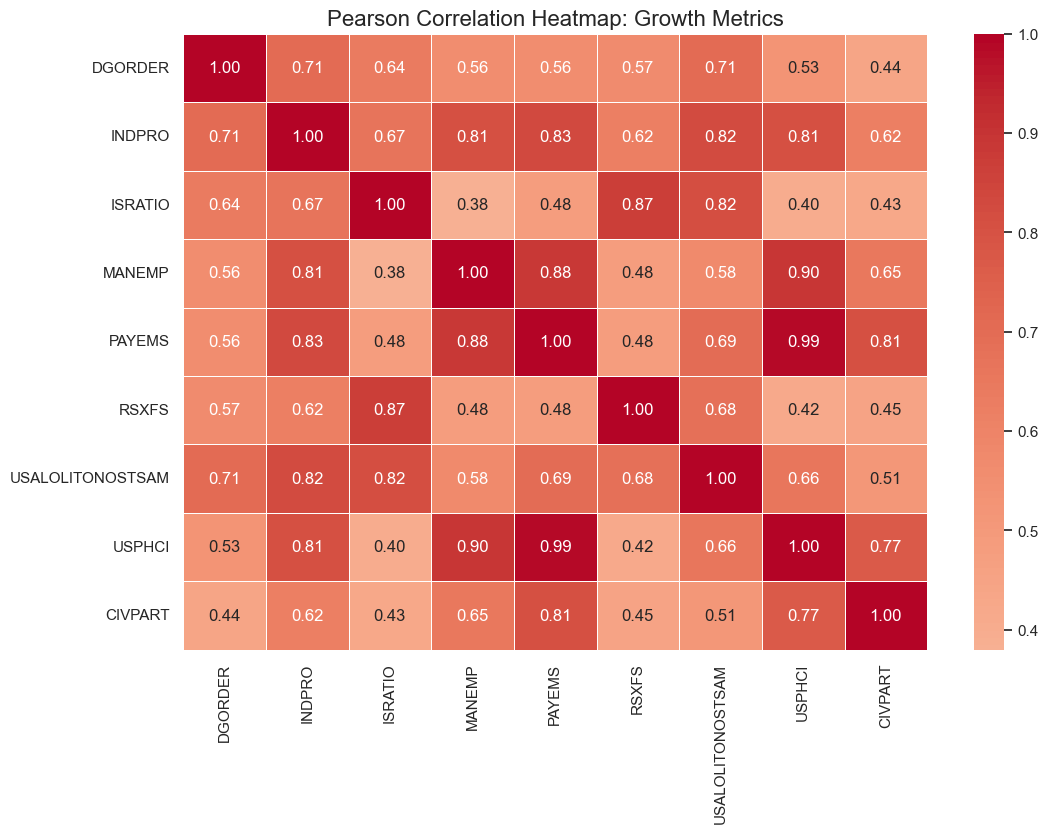


Risk Data Pearson Correlation Heatmap:


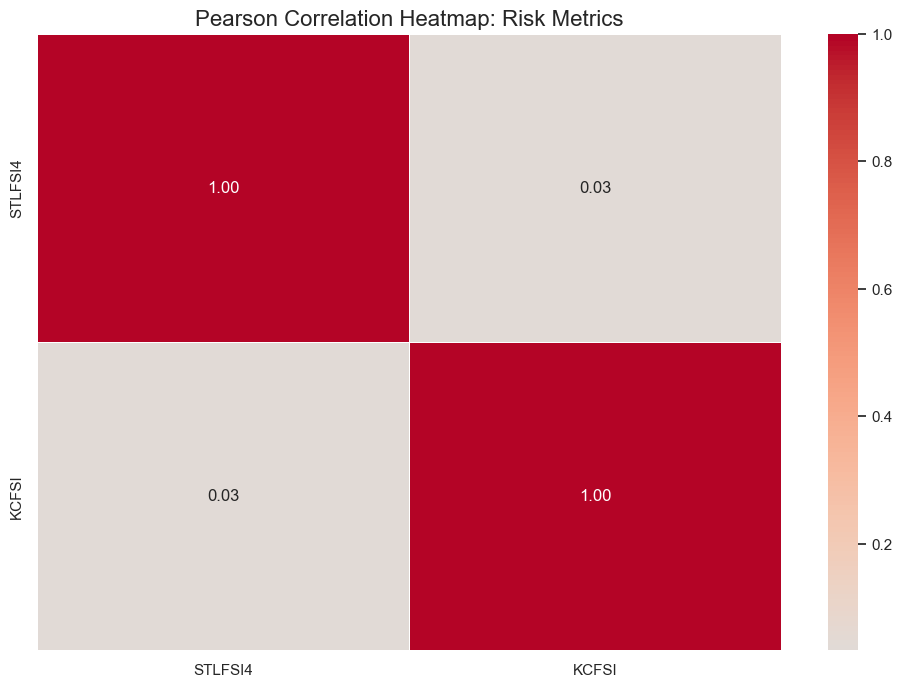


Inflation Data Pearson Correlation Heatmap:


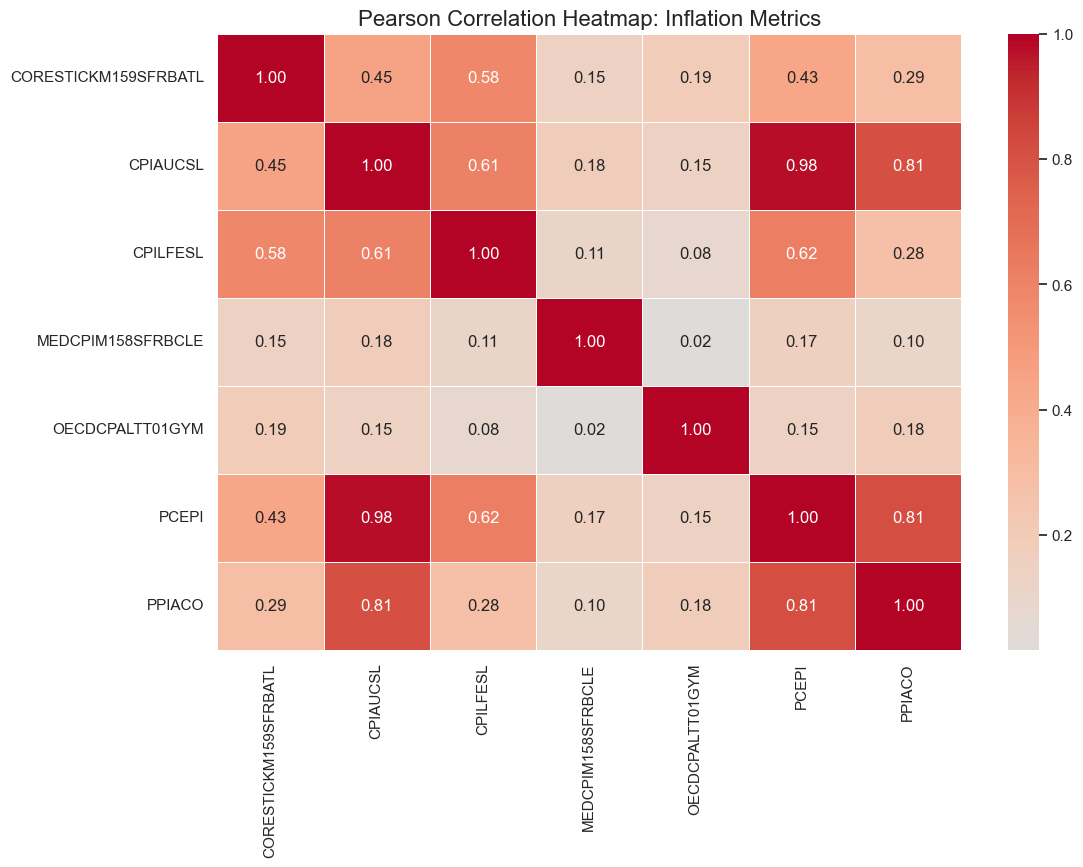


Liquidity Data Pearson Correlation Heatmap:


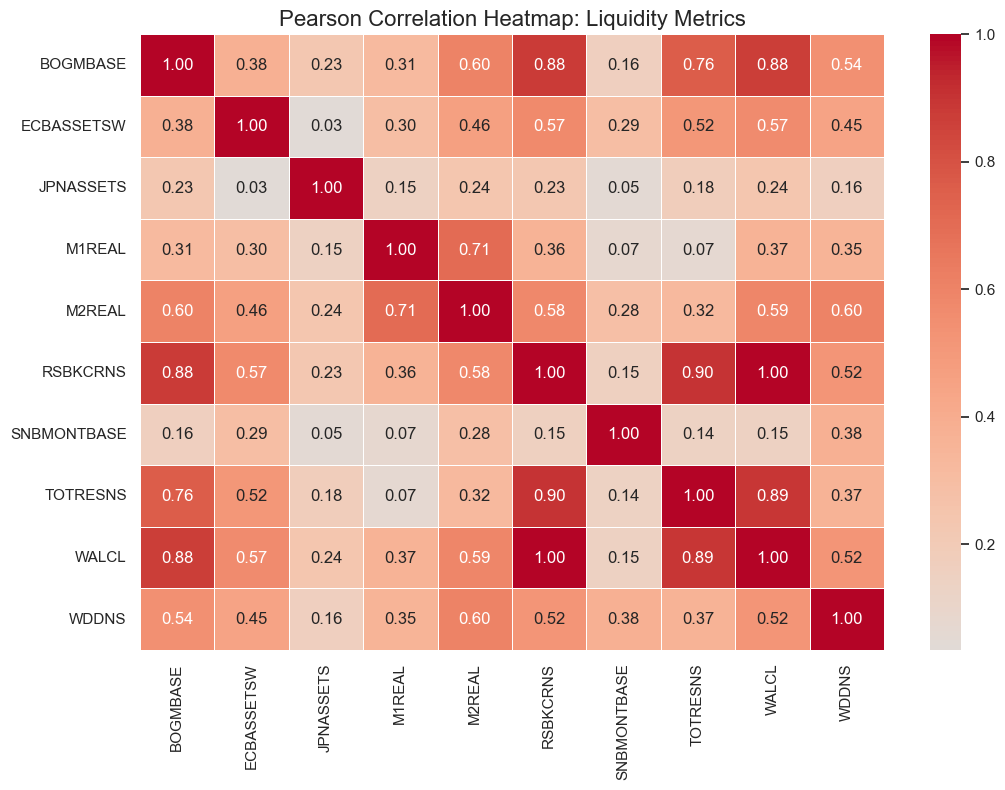


Employment Data Pearson Correlation Heatmap:


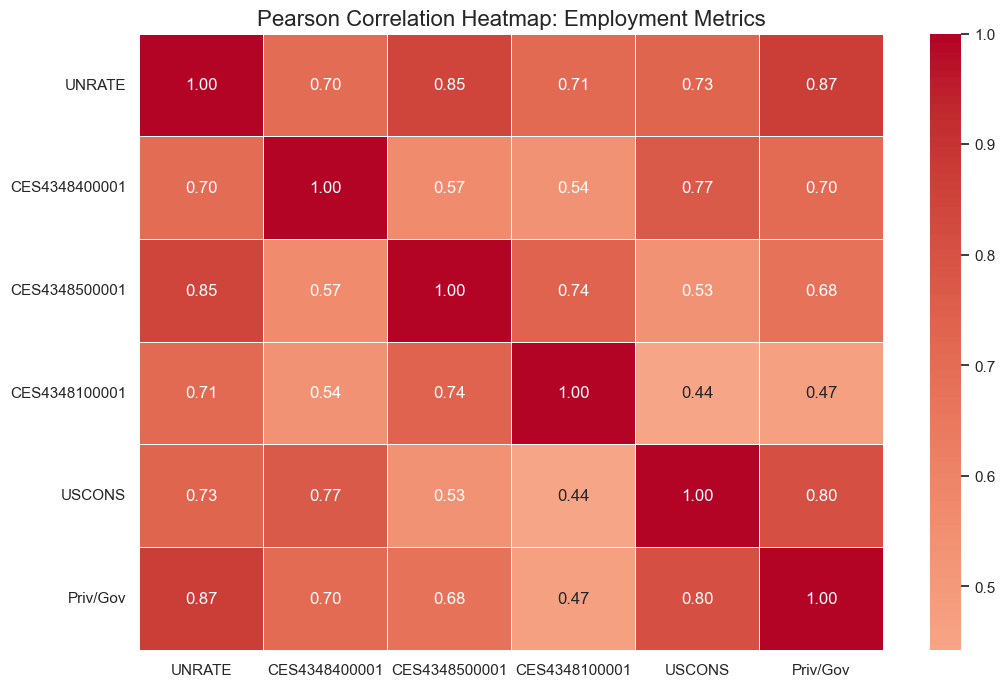


Sentiment Data Pearson Correlation Heatmap:


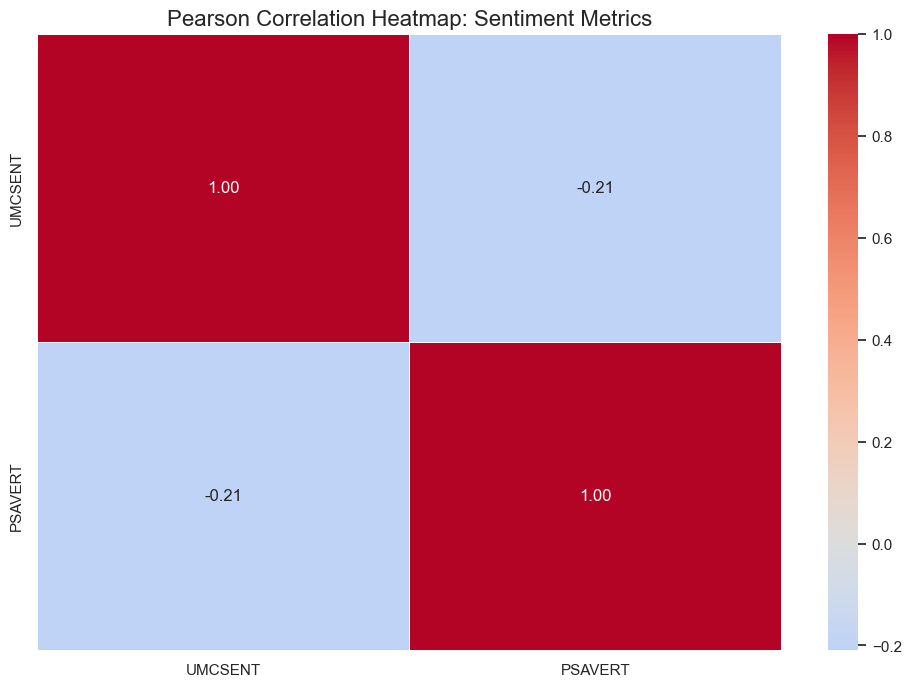

In [23]:
# Function to plot the Pearson correlation heatmap
def plot_pearson_correlation_heatmap(df, title):
    # Calculate the Pearson correlation matrix
    corr = df.corr(method='pearson')

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=.5)

    # Add titles and labels
    plt.title(f'Pearson Correlation Heatmap: {title}', fontsize=16)
    plt.show()

# Plot the heatmap for each DataFrame
print("\nGrowth Data Pearson Correlation Heatmap:")
plot_pearson_correlation_heatmap(growth_df_pct_change, 'Growth Metrics')

print("\nRisk Data Pearson Correlation Heatmap:")
plot_pearson_correlation_heatmap(risk_df_pct_change, 'Risk Metrics')

print("\nInflation Data Pearson Correlation Heatmap:")
plot_pearson_correlation_heatmap(inflation_df_pct_change, 'Inflation Metrics')

print("\nLiquidity Data Pearson Correlation Heatmap:")
plot_pearson_correlation_heatmap(liquidity_df_pct_change, 'Liquidity Metrics')

print("\nEmployment Data Pearson Correlation Heatmap:")
plot_pearson_correlation_heatmap(employ_df_pct_change, 'Employment Metrics')

print("\nSentiment Data Pearson Correlation Heatmap:")
plot_pearson_correlation_heatmap(sentiment_df_pct_change, 'Sentiment Metrics')



### Spearmen


Growth Data Spearman Correlation Heatmap:


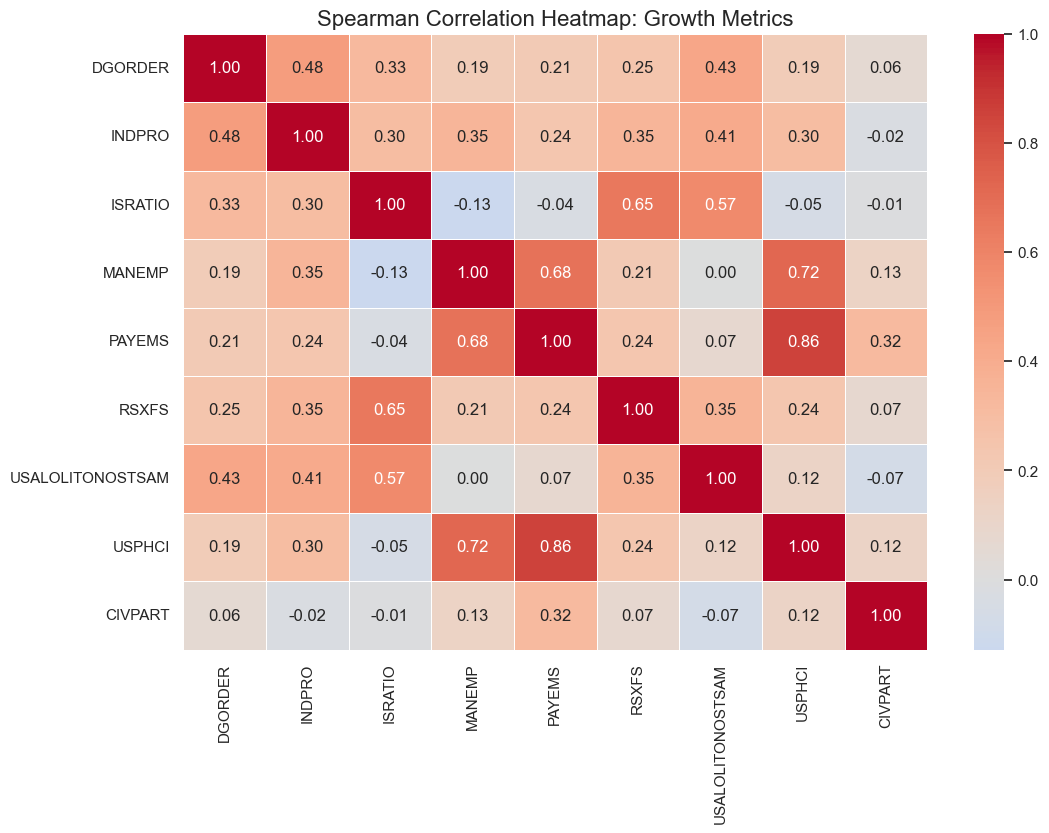


Risk Data Spearman Correlation Heatmap:


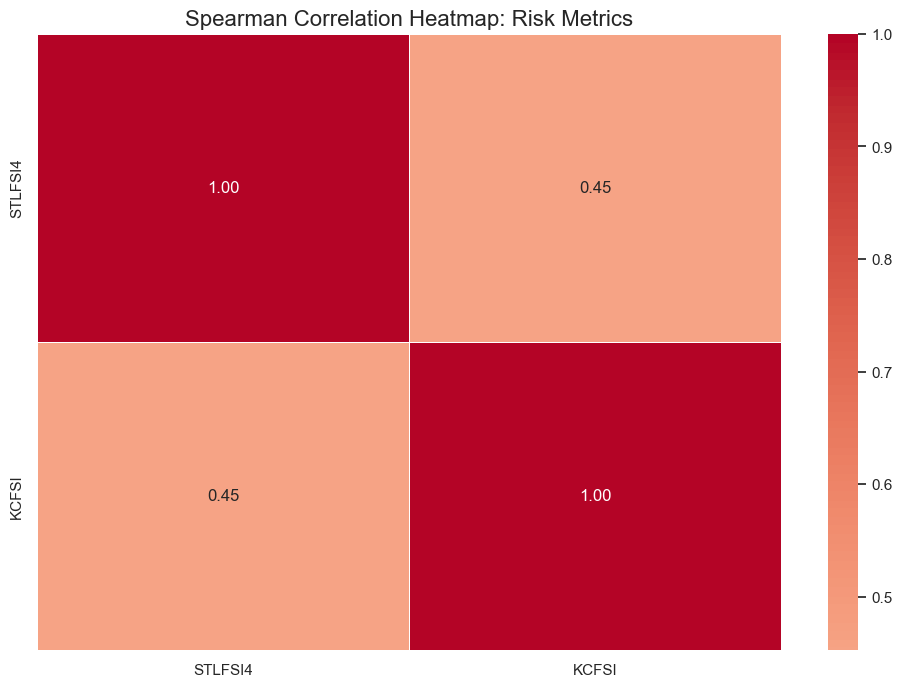


Inflation Data Spearman Correlation Heatmap:


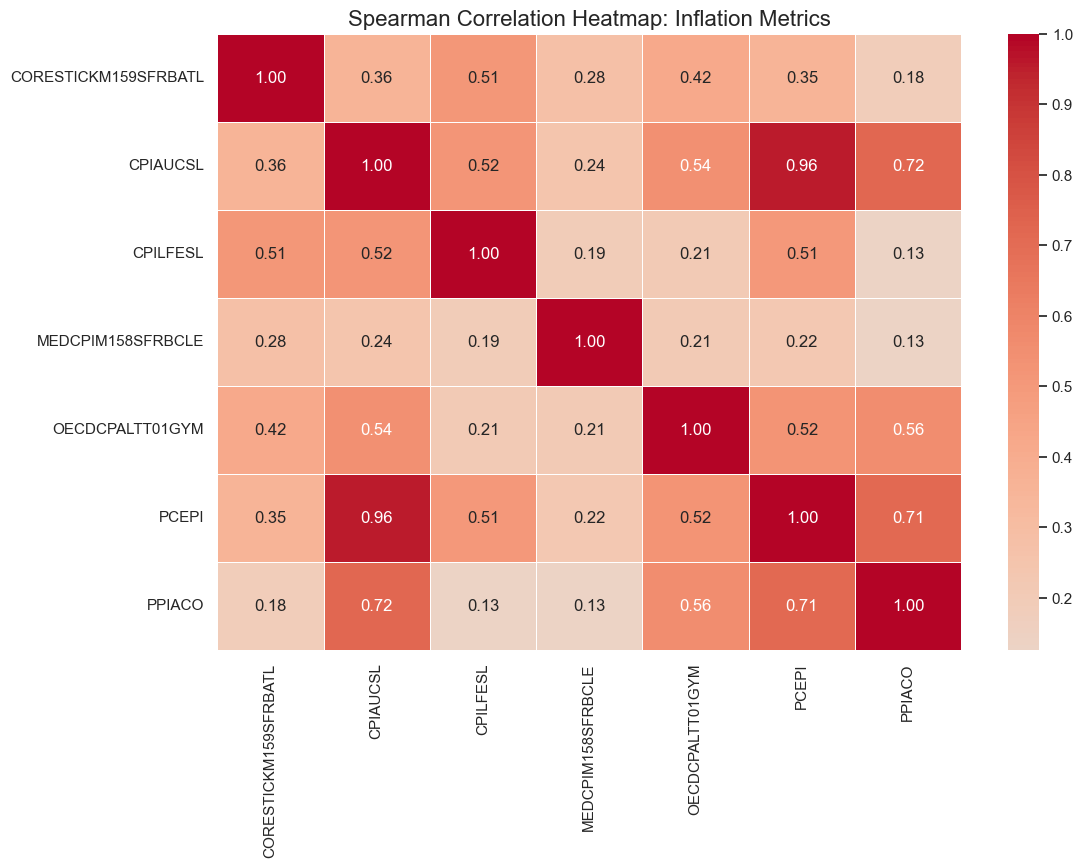


Liquidity Data Spearman Correlation Heatmap:


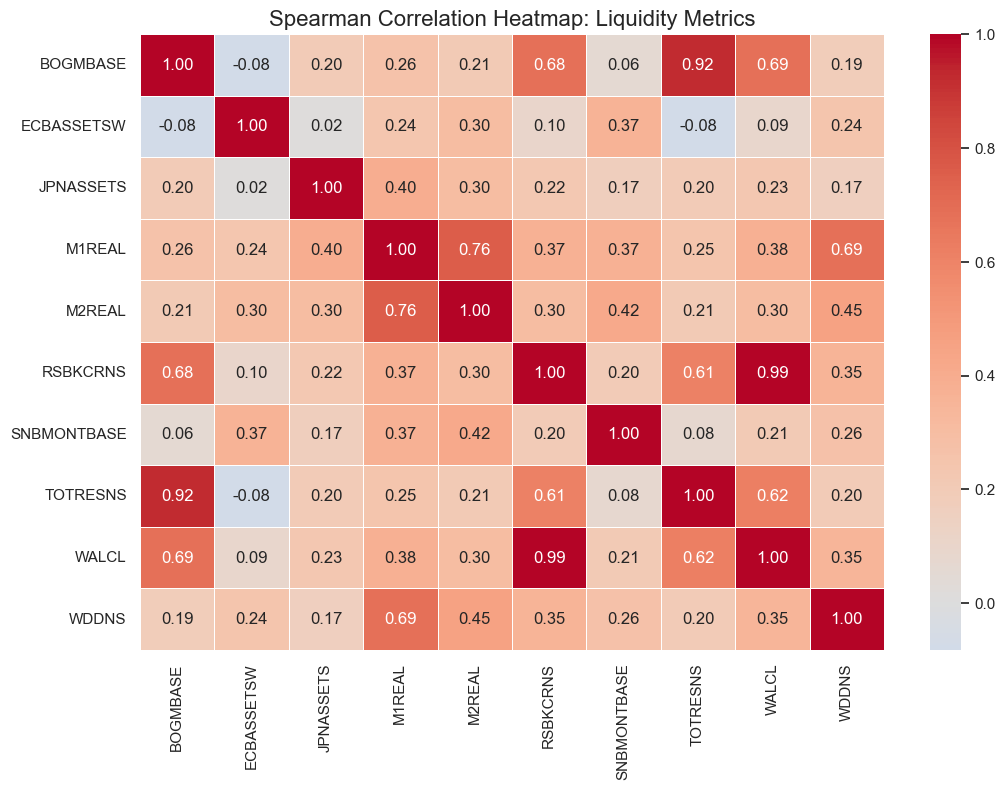


Employment Data Spearman Correlation Heatmap:


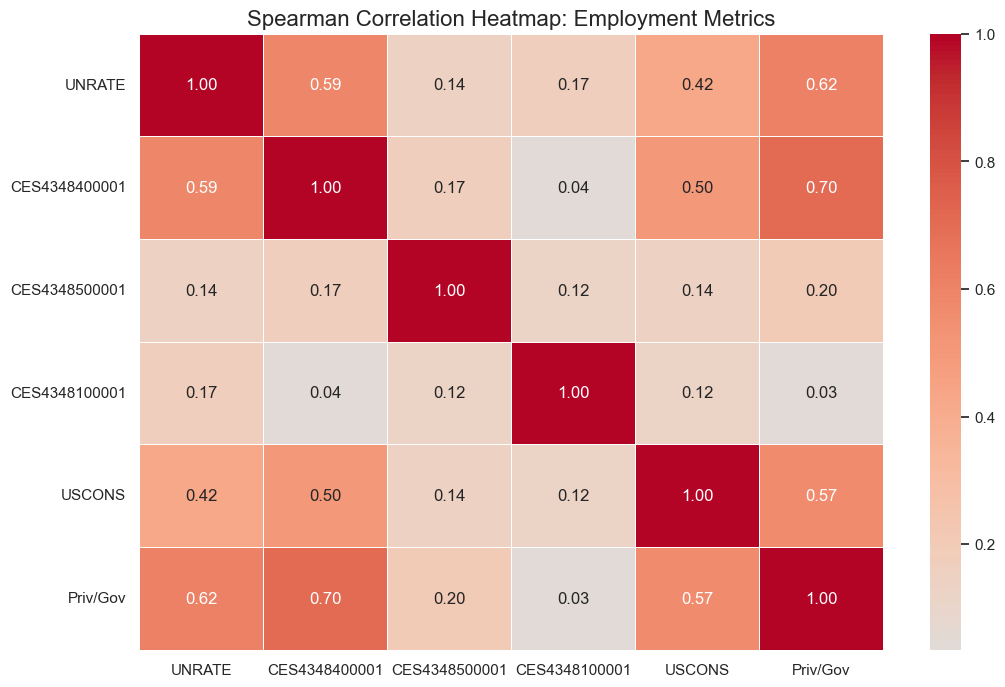


Sentiment Data Spearman Correlation Heatmap:


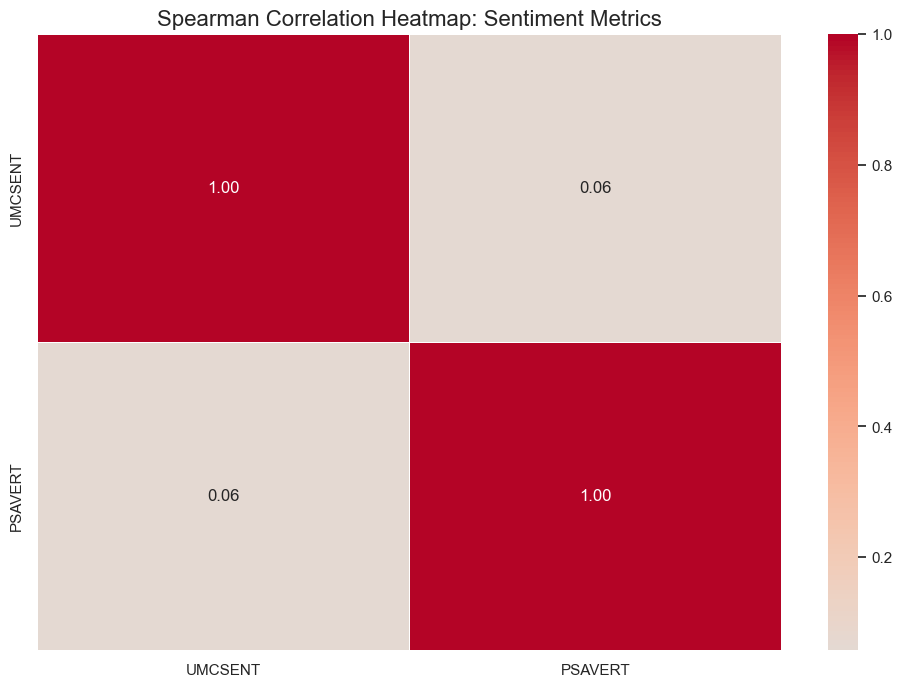

In [24]:
# Function to plot the Spearman correlation heatmap
def plot_spearman_correlation_heatmap(df, title):
    # Calculate the Spearman correlation matrix
    corr = df.corr(method='spearman')

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=.5)

    # Add titles and labels
    plt.title(f'Spearman Correlation Heatmap: {title}', fontsize=16)
    plt.show()

# Plot the heatmap for each DataFrame
print("\nGrowth Data Spearman Correlation Heatmap:")
plot_spearman_correlation_heatmap(growth_df_pct_change, 'Growth Metrics')

print("\nRisk Data Spearman Correlation Heatmap:")
plot_spearman_correlation_heatmap(risk_df_pct_change, 'Risk Metrics')

print("\nInflation Data Spearman Correlation Heatmap:")
plot_spearman_correlation_heatmap(inflation_df_pct_change, 'Inflation Metrics')

print("\nLiquidity Data Spearman Correlation Heatmap:")
plot_spearman_correlation_heatmap(liquidity_df_pct_change, 'Liquidity Metrics')

print("\nEmployment Data Spearman Correlation Heatmap:")
plot_spearman_correlation_heatmap(employ_df_pct_change, 'Employment Metrics')

print("\nSentiment Data Spearman Correlation Heatmap:")
plot_spearman_correlation_heatmap(sentiment_df_pct_change, 'Sentiment Metrics')

### Kendall


Growth Data Kendall Tau Correlation Heatmap:


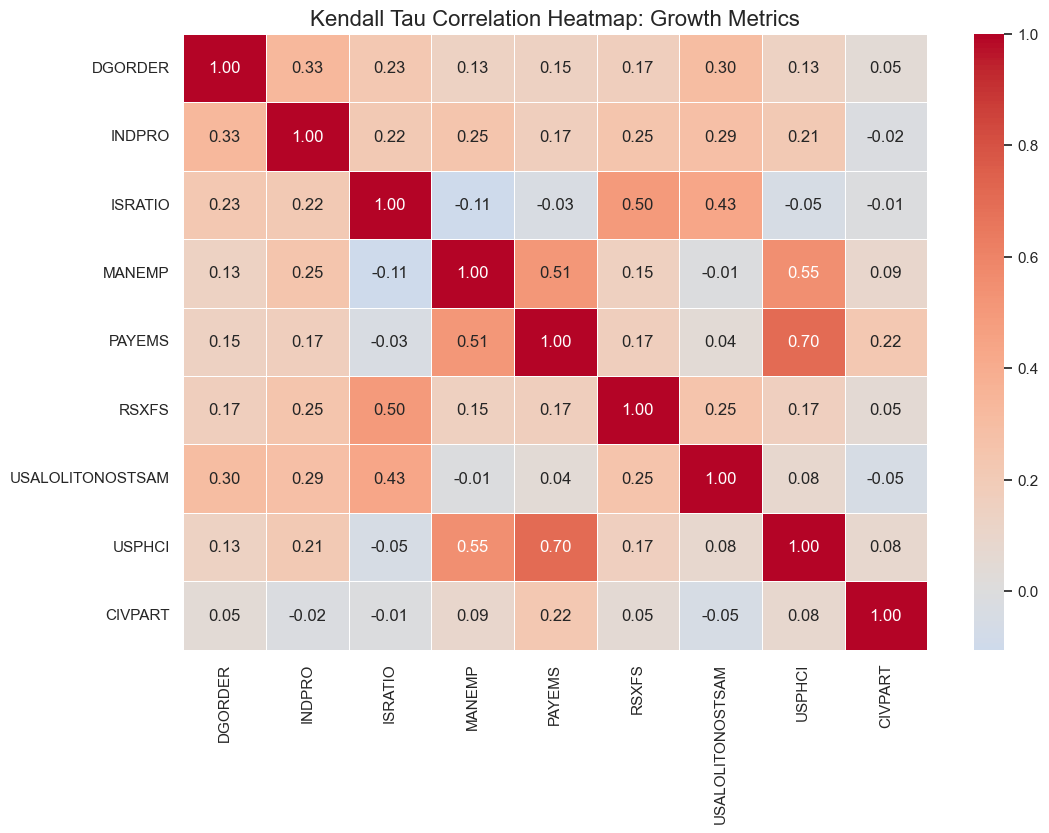


Risk Data Kendall Tau Correlation Heatmap:


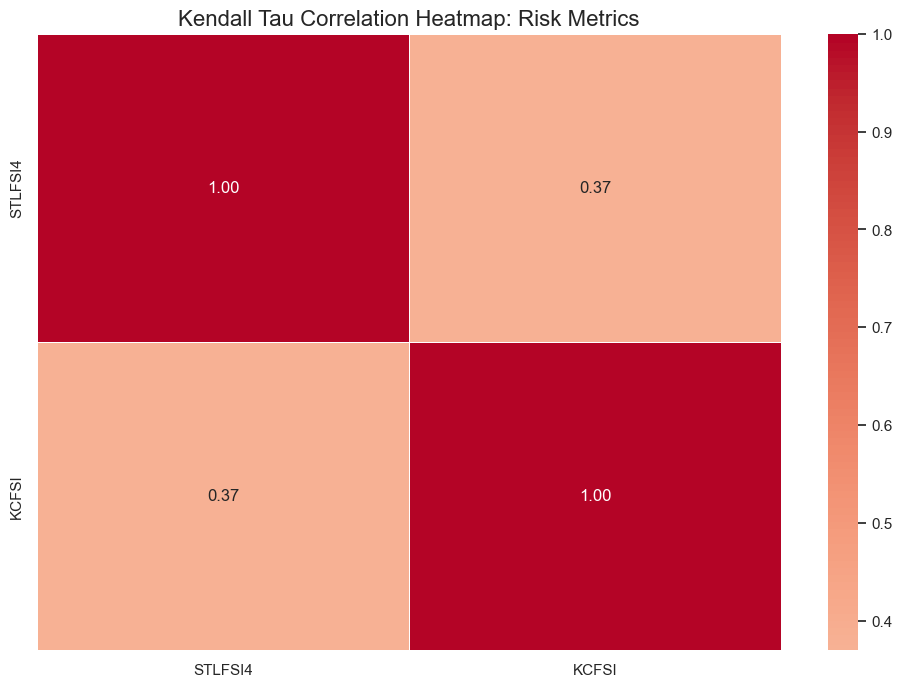


Inflation Data Kendall Tau Correlation Heatmap:


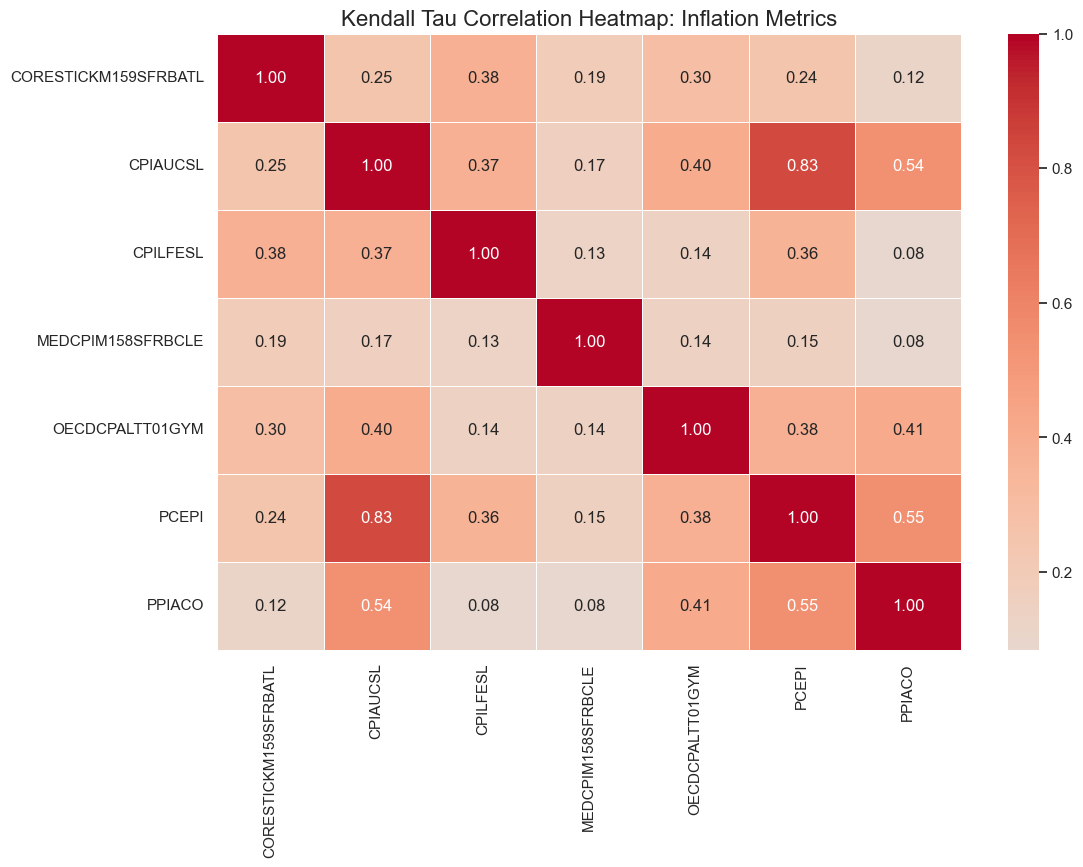


Liquidity Data Kendall Tau Correlation Heatmap:


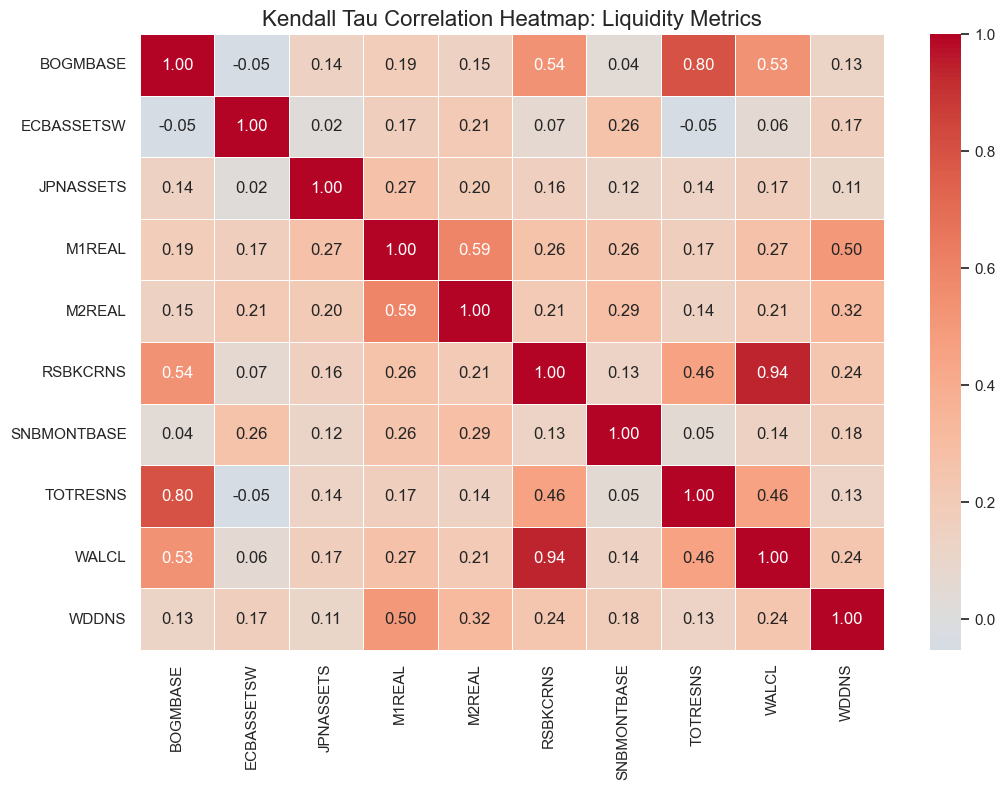


Employment Data Kendall Tau Correlation Heatmap:


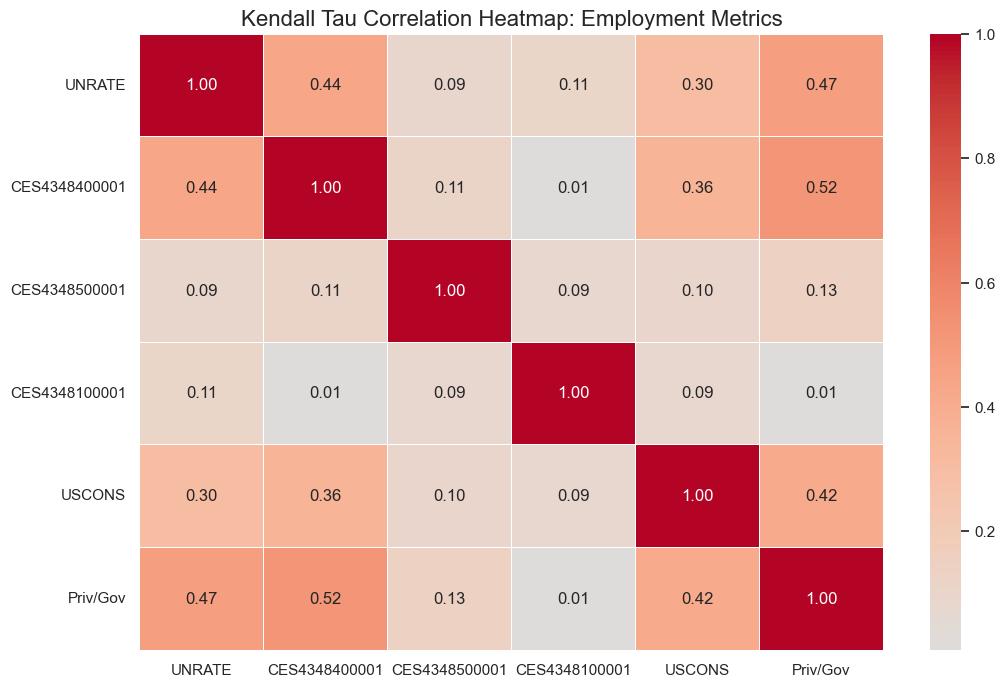


Sentiment Data Kendall Tau Correlation Heatmap:


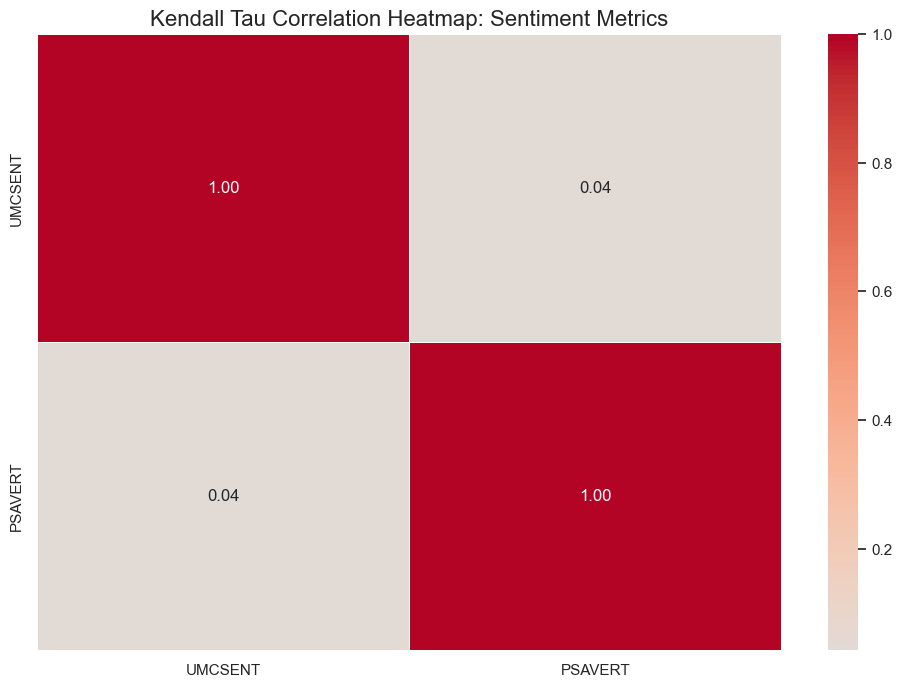

In [25]:
# Function to plot the Kendall Tau correlation heatmap
def plot_kendall_tau_heatmap(df, title):
    # Calculate the Kendall Tau correlation matrix
    corr = df.corr(method='kendall')

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=.5)

    # Add titles and labels
    plt.title(f'Kendall Tau Correlation Heatmap: {title}', fontsize=16)
    plt.show()

# Plot the heatmap for each DataFrame
print("\nGrowth Data Kendall Tau Correlation Heatmap:")
plot_kendall_tau_heatmap(growth_df_pct_change, 'Growth Metrics')

print("\nRisk Data Kendall Tau Correlation Heatmap:")
plot_kendall_tau_heatmap(risk_df_pct_change, 'Risk Metrics')

print("\nInflation Data Kendall Tau Correlation Heatmap:")
plot_kendall_tau_heatmap(inflation_df_pct_change, 'Inflation Metrics')

print("\nLiquidity Data Kendall Tau Correlation Heatmap:")
plot_kendall_tau_heatmap(liquidity_df_pct_change, 'Liquidity Metrics')

print("\nEmployment Data Kendall Tau Correlation Heatmap:")
plot_kendall_tau_heatmap(employ_df_pct_change, 'Employment Metrics')

print("\nSentiment Data Kendall Tau Correlation Heatmap:")
plot_kendall_tau_heatmap(sentiment_df_pct_change, 'Sentiment Metrics')

## Scenario Analysis

### Scenario Creation

In [26]:
# Step 1: Calculate the sum of all metrics within each DataFrame
growth_sum = growth_df_pct_change.sum(axis=1)
inflation_sum = inflation_df_pct_change.sum(axis=1)
risk_sum = risk_df_pct_change.sum(axis=1)
liquidity_sum = liquidity_df_pct_change.sum(axis=1)
sentiment_sum = sentiment_df_pct_change.sum(axis=1)
employ_sum = employ_df_pct_change.sum(axis=1)

scenarios = pd.DataFrame()

# Adding columns for the raw indicator values before mapping to 1 or -1
scenarios['Growth'] = growth_sum
scenarios['Risk'] = risk_sum
scenarios['Inflation'] = inflation_sum
scenarios['Liquidity'] = liquidity_sum
scenarios['Employ'] = employ_sum
scenarios['Sentiment'] = sentiment_sum



# Step 3: Convert positive values to 1 and negative or zero values to 0
scenarios['Growth_Indicator'] = np.where(scenarios['Growth'] > 0, 1, 0)
scenarios['Risk_Indicator'] = np.where(scenarios['Risk'] > 0, 1, 0)
scenarios['Inflation_Indicator'] = np.where(scenarios['Inflation'] > 0, 1, 0)
scenarios['Liquidity_Indicator'] = np.where(scenarios['Liquidity'] > 0, 1, 0)
scenarios['Employ_Indicator'] = np.where(scenarios['Employ'] > 0, 1, 0)
scenarios['Sentiment_Indicator'] = np.where(scenarios['Sentiment'] > 0, 1, 0)

# Display the resulting DataFrame
scenarios

,Growth,Risk,Inflation,Liquidity,Employ,Sentiment,Growth_Indicator,Risk_Indicator,Inflation_Indicator,Liquidity_Indicator,Employ_Indicator,Sentiment_Indicator
2003-04-30,-11.644966,-1.107682,-5.153267,0.732697,-6.678135,0.106419,0,0,0,1,0,1
2003-05-31,-8.692182,-1.696027,-7.272483,2.942254,-6.227450,1.542687,0,0,0,1,0,1
2003-06-30,-5.881731,-1.756878,-7.118111,1.936011,-6.282247,1.681688,0,0,0,1,0,1
2003-07-31,-1.461214,-3.038836,5.775575,3.165061,-6.052205,1.414545,0,0,1,1,0,1
2003-08-31,-0.646192,2.809714,2.014340,1.947918,-3.122348,0.045231,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,-3.655859,0.752973,2.610983,-4.315167,-1.234770,2.435228,0,1,1,0,0,1
2024-03-31,-0.288909,1.356954,4.717132,-5.075505,-1.244660,1.177119,0,1,1,0,0,1
2024-04-30,1.391332,0.394605,3.092092,-5.883384,-0.764646,-0.879861,1,1,1,0,0,0
2024-05-31,-0.714093,0.921618,0.474368,-6.270904,-1.200950,-1.289910,0,1,1,0,0,0


### TS Plot

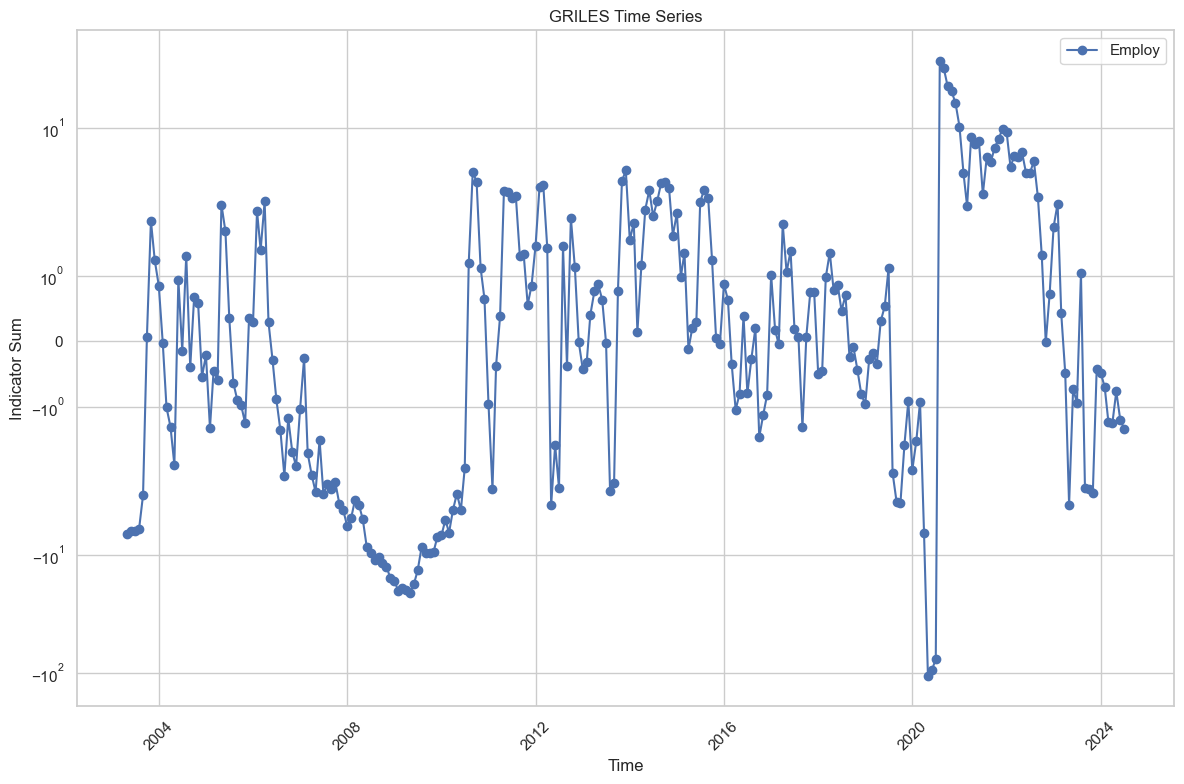

In [27]:
# Step 5: Plot the time series of Growth, Inflation, Risk, and Liquidity indicators with logarithmic y-scale
plt.figure(figsize=(12, 8))

#plt.plot(scenarios.index, scenarios['Growth'], label='Growth', marker='o')
#plt.plot(scenarios.index, scenarios['Risk'], label='Risk', marker='s')
#plt.plot(scenarios.index, scenarios['Inflation'], label='Inflation', marker='x')
#plt.plot(scenarios.index, scenarios['Liquidity'], label='Liquidity', marker='^')
plt.plot(scenarios.index, scenarios['Employ'], label='Employ', marker='o')
#plt.plot(scenarios.index, scenarios['Sentiment'], label='Sentiment', marker='X')


# Adding titles and labels
plt.title('GRILES Time Series')
plt.xlabel('Time')
plt.ylabel('Indicator Sum')

# Set y-axis to logarithmic scale
plt.yscale('symlog')

# Adding legend
plt.legend(loc='best')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### Weiner Check


Results for Growth:
  - Normality test failed (p-value = 0.0000)
  - Mean of increments is not close to zero (mean = 0.0305)
  - Variance increases with time (slope = 1.2328)

Growth does NOT appear to be a Wiener process.



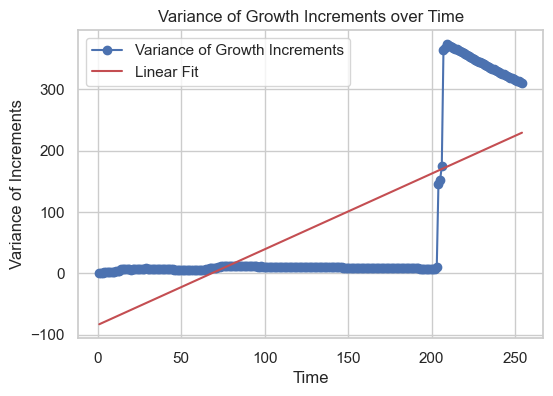


Results for Risk:
  - Normality test failed (p-value = 0.0000)
  - Mean of increments is close to zero (mean = 0.0058)
  - Variance increases with time (slope = 5.2617)

Risk does NOT appear to be a Wiener process.



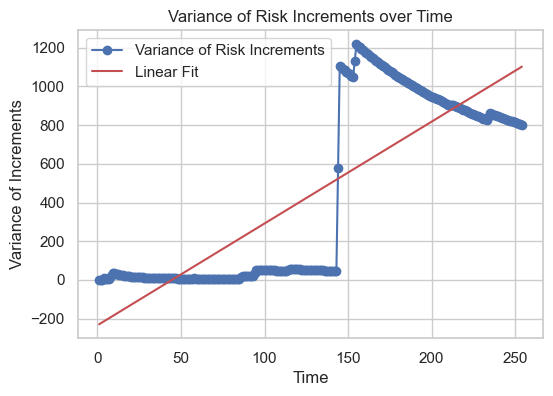


Results for Inflation:
  - Normality test failed (p-value = 0.0000)
  - Mean of increments is close to zero (mean = 0.0098)
  - Variance increases with time (slope = 0.0705)

Inflation does NOT appear to be a Wiener process.



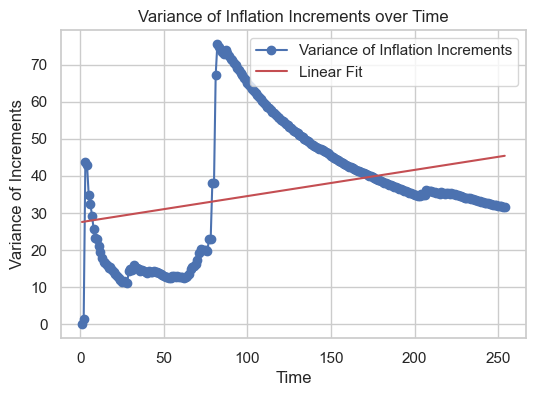


Results for Liquidity:
  - Normality test failed (p-value = 0.0000)
  - Mean of increments is not close to zero (mean = -0.0257)
  - Variance increases with time (slope = 1.3097)

Liquidity does NOT appear to be a Wiener process.



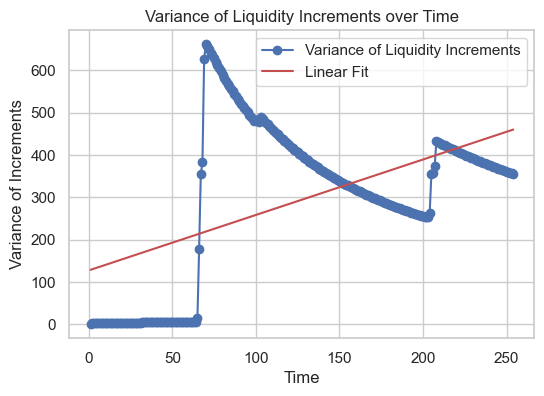


Results for Employ:
  - Normality test failed (p-value = 0.0000)
  - Mean of increments is not close to zero (mean = 0.0210)
  - Variance increases with time (slope = 0.3762)

Employ does NOT appear to be a Wiener process.



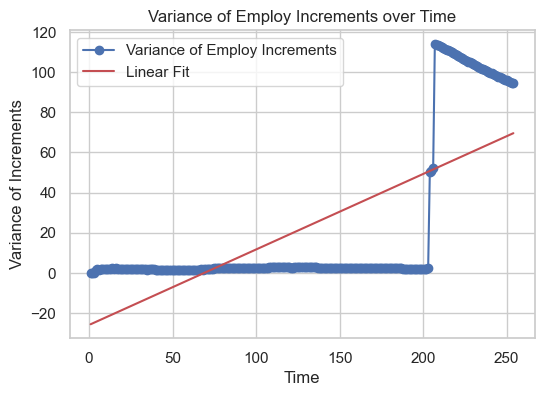


Results for Sentiment:
  - Normality test failed (p-value = 0.0000)
  - Mean of increments is close to zero (mean = -0.0065)
  - Variance increases with time (slope = 0.0042)

Sentiment does NOT appear to be a Wiener process.



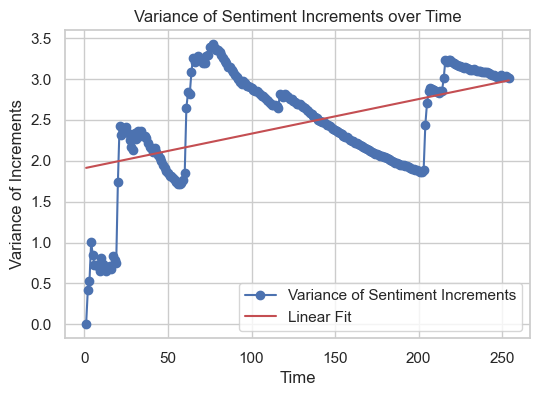

In [28]:
# Function to calculate increments
def calculate_increments(series):
    return series.diff().dropna()

# Function to test if a series is a Wiener process
def test_wiener_process(series, series_name):
    increments = calculate_increments(series)
    
    # Test 1: Normality Test of Increments
    normality_test_stat, normality_p_value = normaltest(increments)
    
    # Test 2: Mean of Increments
    mean_increment = np.mean(increments)
    
    # Test 3: Variance proportional to time
    # Regress variance of increments against time intervals
    time_intervals = np.arange(1, len(increments) + 1)
    variance_increments = [np.var(increments[:i]) for i in range(1, len(increments) + 1)]
    slope, intercept, r_value, p_value, std_err = linregress(time_intervals, variance_increments)
    
    # Check conditions for Wiener process and print conclusions
    print(f"\nResults for {series_name}:")
    
    # Normality test check
    if normality_p_value > 0.05:
        print(f"  - Normality test passed (p-value = {normality_p_value:.4f})")
        normality_condition = True
    else:
        print(f"  - Normality test failed (p-value = {normality_p_value:.4f})")
        normality_condition = False
    
    # Mean of increments check (close to zero)
    if np.abs(mean_increment) < 1e-2:  # small threshold to check if mean is close to zero
        print(f"  - Mean of increments is close to zero (mean = {mean_increment:.4f})")
        mean_condition = True
    else:
        print(f"  - Mean of increments is not close to zero (mean = {mean_increment:.4f})")
        mean_condition = False
    
    # Variance vs time proportionality check
    if slope > 0:
        print(f"  - Variance increases with time (slope = {slope:.4f})")
        variance_condition = True
    else:
        print(f"  - Variance does not increase with time (slope = {slope:.4f})")
        variance_condition = False
    
    # Final conclusion
    if normality_condition and mean_condition and variance_condition:
        print(f"\n{series_name} appears to be a Wiener process.\n")
    else:
        print(f"\n{series_name} does NOT appear to be a Wiener process.\n")

    # Plotting the variance vs time to visually inspect proportionality
    plt.figure(figsize=(6, 4))
    plt.plot(time_intervals, variance_increments, marker='o', label=f'Variance of {series_name} Increments')
    plt.plot(time_intervals, intercept + slope * time_intervals, color='r', label='Linear Fit')
    plt.title(f'Variance of {series_name} Increments over Time')
    plt.xlabel('Time')
    plt.ylabel('Variance of Increments')
    plt.legend()
    plt.show()

# Apply the Wiener process test to each series
for series_name in ['Growth', 'Risk', 'Inflation', 'Liquidity', 'Employ', 'Sentiment']:
    if series_name in scenarios.columns:
        test_wiener_process(scenarios[series_name], series_name)


### Index Correlations

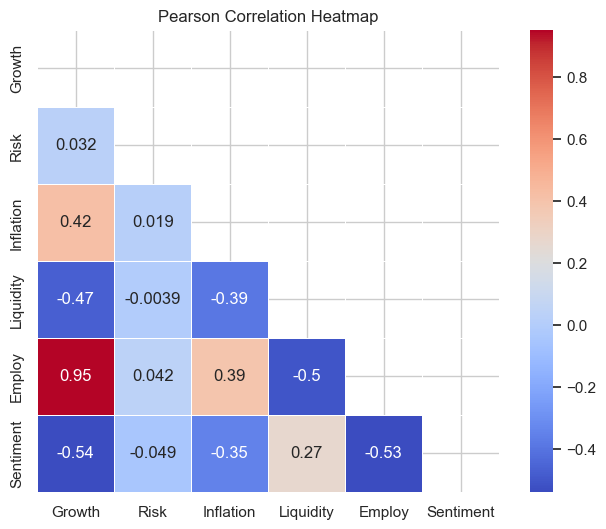

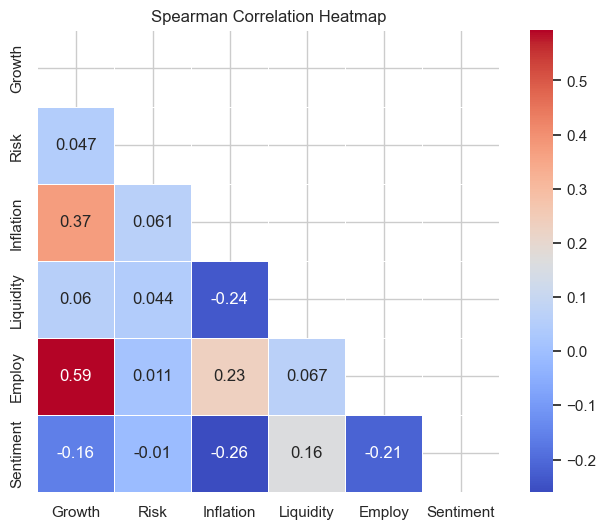

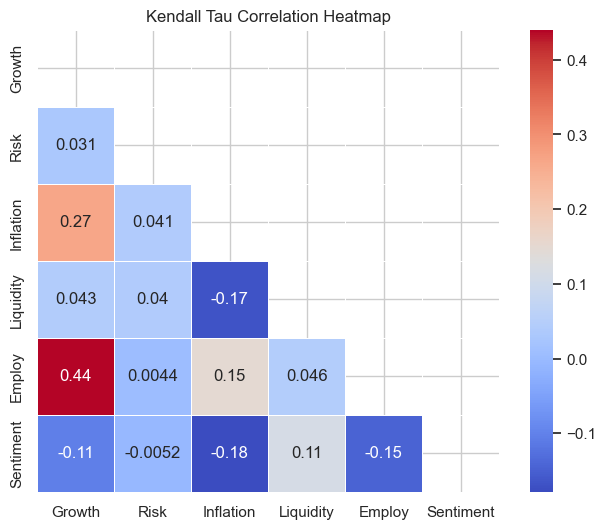

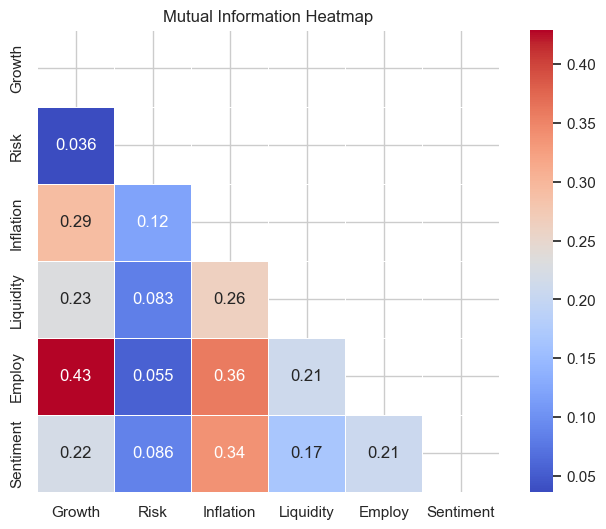

In [29]:
# Function to calculate mutual information between two variables
def calculate_mutual_info(x, y):
    return mutual_info_score(None, None, contingency=np.histogram2d(x, y, bins=20)[0])

# Calculate Pearson, Spearman, Kendall Tau correlations and mutual information
pearson_corr = scenarios[['Growth', 'Risk', 'Inflation', 'Liquidity', 'Employ', 'Sentiment']].corr(method='pearson')
spearman_corr = scenarios[['Growth',  'Risk', 'Inflation', 'Liquidity', 'Employ', 'Sentiment']].corr(method='spearman')
kendall_corr = scenarios[['Growth', 'Risk', 'Inflation', 'Liquidity', 'Employ', 'Sentiment']].corr(method='kendall')

# Mutual Information matrix
columns = ['Growth', 'Risk', 'Inflation',  'Liquidity', 'Employ', 'Sentiment', ]
mutual_info = pd.DataFrame(index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        mutual_info.loc[col1, col2] = calculate_mutual_info(scenarios[col1], scenarios[col2])

mutual_info = mutual_info.astype(float)

# Define a function to create triangular heatmaps
def plot_triangular_heatmap(data, title):
    mask = np.triu(np.ones_like(data, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, mask=mask, annot=True, cmap="coolwarm", square=True, linewidths=0.5)
    plt.title(title)
    plt.show()

# Plotting the triangular heatmaps
plot_triangular_heatmap(pearson_corr, 'Pearson Correlation Heatmap')
plot_triangular_heatmap(spearman_corr, 'Spearman Correlation Heatmap')
plot_triangular_heatmap(kendall_corr, 'Kendall Tau Correlation Heatmap')
plot_triangular_heatmap(mutual_info, 'Mutual Information Heatmap')


### Granger Causality

In [30]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Granger causality test between all combinations of GRILES indicators
def granger_causality_statements(data, max_lag, significance_level=0.05):
    variables = data.columns
    significant_relations = []

    for col1 in variables:
        for col2 in variables:
            if col1 != col2:
                # Granger causality test (col1 causing col2)
                test_result = grangercausalitytests(data[[col2, col1]], max_lag, verbose=False)
                p_values = [test_result[i + 1][0]['ssr_ftest'][1] for i in range(max_lag)]
                min_p_value = np.min(p_values)
                best_lag = np.argmin(p_values) + 1  # Lags are 1-indexed
                
                # Check significance
                if min_p_value < significance_level:
                    significant_relations.append(f"{col1} --> {col2} (p-value: {min_p_value:.4f}, lag: {best_lag})")

    return significant_relations

# Running Granger causality tests with a maximum lag of 12
max_lag = 12
significance_level = 0.001
significant_relations = granger_causality_statements(scenarios[['Growth', 'Risk', 'Inflation', 'Liquidity', 'Employ', 'Sentiment']], max_lag, significance_level)

# Displaying the significant Granger causality relations
if significant_relations:
    for relation in significant_relations:
        print(relation)
else:
    print("No significant Granger causality relationships found.")

Growth --> Liquidity (p-value: 0.0000, lag: 4)
Growth --> Employ (p-value: 0.0000, lag: 2)
Growth --> Sentiment (p-value: 0.0001, lag: 9)
Liquidity --> Growth (p-value: 0.0000, lag: 3)
Liquidity --> Inflation (p-value: 0.0003, lag: 12)
Liquidity --> Employ (p-value: 0.0000, lag: 3)
Employ --> Growth (p-value: 0.0000, lag: 1)
Employ --> Liquidity (p-value: 0.0000, lag: 4)
Employ --> Sentiment (p-value: 0.0001, lag: 10)
Sentiment --> Growth (p-value: 0.0010, lag: 6)
Sentiment --> Inflation (p-value: 0.0003, lag: 5)
Sentiment --> Liquidity (p-value: 0.0000, lag: 1)
Sentiment --> Employ (p-value: 0.0000, lag: 1)


## Forecasts

### VAR

In [31]:
# Set the forecast horizon for the VAR model (e.g., forecasting 8 steps ahead)
forecast_horizon = 8  # Adjust the forecast horizon as needed

# Dictionary to store the actual and forecasted values for future use (if needed)
forecast_results = {}

# Select relevant columns for the VAR model from the scenarios DataFrame
columns_of_interest = ['Growth', 'Risk', 'Inflation', 'Liquidity', 'Employ', 'Sentiment']
df_var = scenarios[columns_of_interest]

# Fit the VAR model to the selected columns
model = VAR(df_var)
model_fit = model.fit(maxlags=24, ic='aic')  # Choose the optimal lag based on AIC

# Forecast the next 'forecast_horizon' steps ahead
forecast_values = model_fit.forecast(df_var.values[-model_fit.k_ar:], steps=forecast_horizon)

# Convert the forecasted values to a DataFrame with appropriate column names
forecast_df = pd.DataFrame(forecast_values, columns=columns_of_interest)

# Generate a date range for the forecast, continuing from the last date of the original data
last_date = df_var.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')

# Assign the generated date range as the index of the forecast DataFrame
forecast_df.index = forecast_dates

# Extract the last 6 actual data points from the original DataFrame
last_6_actual = df_var.iloc[-6:]

# Combine the last 6 actual data points with the forecasted values
combined_df = pd.concat([last_6_actual, forecast_df])

# Print the final DataFrame containing actual and forecasted values
print("GRILES Framework Forecast Values:")
combined_df.tail(10)

GRILES Framework Forecast Values:


,Growth,Risk,Inflation,Liquidity,Employ,Sentiment
2024-05-31,-0.714093,0.921618,0.474368,-6.270904,-1.200950,-1.289910
2024-06-30,-3.909053,0.376122,-2.675349,-5.782739,-1.332455,-1.547680
2024-07-31,-8.087717,-1.466530,-1.496976,-0.422913,-3.209843,-0.040276
2024-08-31,-10.266367,-0.286164,-1.809682,9.204010,-4.876396,0.472921
2024-09-30,-8.628566,0.832946,-2.600389,13.270445,-5.383322,0.820176
2024-10-31,-2.314006,1.704305,-1.684795,8.708032,-2.822675,0.374319
2024-11-30,1.400982,1.639412,0.032510,-0.142095,-0.881092,0.197567
2024-12-31,1.563472,1.667538,0.699394,-4.090305,-0.180509,0.024445
2025-01-31,-1.408819,1.581076,0.271167,-2.128432,-1.259067,0.151718
2025-02-28,-2.866369,1.069157,-0.323022,2.937153,-1.816577,0.206602
